# MDS
25.03.2021

# Autorzy:
- Aleksander Stańdo
- Jakub Pasich
- Jan Gąsienica-Józkowy

# Multi-Dimension Scaling 
is a distance-preserving manifold learning method. All manifold learning algorithms assume the dataset lies on a smooth, non linear manifold of low dimension and that a mapping f: $R^{D}$ -> $R^{d}$ (D>>d) can be found by preserving one or more properties of the higher dimension space. Distance preserving methods assume that a manifold can be defined by the pairwise distances of its points. In distance preserving methods, a low dimensional embedding is obtained from the higher dimension in such a way that pairwise distances between the points remain same. Some distance preserving methods preserve spatial distances (MDS) while some preserve graph distances.

MDS is not a single method but a family of methods. MDS takes a dissimilarity matrix $D$ where $D_{ij}$ represents the dissimilarity between points $i$ and $j$ and produces a mapping on a lower dimension, preserving the dissimilarities as closely as possible. The dissimilarity matrix could be observed or calculated from the given dataset.

MDS can be divided into two categories:

- **Metric MDS** - Metric MDS is used for quantitative data and tries to preserve the original dissimilarity metrics. 

- **Non-Metric MDS** - Non-metric MDS is used for ordinal data. It tries to keep the order of dissimialrity metrics intact.

# t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. It is extensively applied in image processing, NLP, genomic data and speech processing. To keep things simple, here’s a brief overview of working of t-SNE:

- The algorithms starts by calculating the probability of similarity of points in high-dimensional space and calculating the probability of similarity of points in the corresponding low-dimensional space. The similarity of points is calculated as the conditional probability that a point A would choose point B as its neighbor if neighbors were picked in proportion to their probability density under a Gaussian (normal distribution) centered at A.

- It then tries to minimize the difference between these conditional probabilities (or similarities) in higher-dimensional and lower-dimensional space for a perfect representation of data points in lower-dimensional space.

- To measure the minimization of the sum of difference of conditional probability t-SNE minimizes the sum of Kullback-Leibler divergence of overall data points using a gradient descent method.


In simpler terms, t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding.

In this way, t-SNE maps the multi-dimensional data to a lower dimensional space and attempts to find patterns in the data by identifying observed clusters based on similarity of data points with multiple features. However, after this process, the input features are no longer identifiable, and you cannot make any inference based only on the output of t-SNE. Hence it is mainly a data exploration and visualization technique.

I recommend to familiarize with this amazing blogpost https://distill.pub/2016/misread-tsne/ which graphically shows traps associated with use of t-SNE and how  hyperparameters selection can  affect final embeding.



### To better illustrate properties of individual methods of reducing dimensionality (from this and previous lab), create a set of points in the shape of a roulade.  To do it:

1. Prepare a point generator for the circles in this generator, ensure that the radius decreases with the next steps (in this way you will get a spiral)

2. Treat the spiral as a cross-sectional solid, creating a croissant / crescent roll

3. Move the points in the roll with a slight noise to avoid their perfect placement

4. For better visualization, you can give individual points a color depending, e.g. on the distance from the center of the roulade

5. Generated roulade should resemble the picture below

In [3]:
from time import time
import math
import random
import mkl
import glob

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from matplotlib.cbook import get_sample_data
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from IPython.display import Image
import tensorflow as tf
from tensorflow import keras

sn.set(color_codes=True)
np.random.seed(1234)
mkl.set_num_threads(4)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [20, 20]



## Roulade points generator

In [4]:
def random_spiral_point(density=2):
    p = random.random()**0.5
    return p*math.cos(p*density*np.pi*2), p*math.sin(p*density*np.pi*2)

def uniform_spiral(density=3, steps = 100):
    x, y = [] ,[]
    for i in range(steps):
        x.append((i/steps)**0.5*math.cos((i/steps)**0.5*density*np.pi*2))
        y.append((i/steps)**0.5*math.sin((i/steps)**0.5*density*np.pi*2))
        
    return x, y
        
def spiral2roll(xli, yli, width=7, angle=0.1):
    nx, ny, nz, d = [], [], [], []
    for x,y in zip(xli, yli):
        p = random.random()
        nx.append((width+x)*math.cos(angle*p*np.pi*2))
        ny.append((width+x)*math.sin(angle*p*np.pi*2))
        nz.append(y)
        d.append((x**2+y**2)**0.5)
    return nx, ny, nz, d

def uniform_roll(xli, yli, width=7, angle=0.25, density=5, noise_factor=0.05):
    nx, ny, nz, d = [], [], [], []
    d1 = [((x**2+y**2)**0.5) for x,y in zip(xli, yli)]
    for i in range(density):
        nx.extend([(width+x)*math.cos(angle*i/density*np.pi*2) + (random.random()-0.5)*noise_factor for x in xli])
        ny.extend([(width+x)*math.sin(angle*i/density*np.pi*2) + (random.random()-0.5)*noise_factor  for x in xli])
        nz.extend(yli)
        d.extend(d1) 
    return nx, ny, nz, d  


def roll_generator(to_array=True, spiral_density=3, spiral_steps = 20, width=7, angle=0.3, density=5):
    x, y = uniform_spiral(density=spiral_density, steps = spiral_steps)
    x,y,z,d = uniform_roll(x, y, width=width, angle=angle, density=density)
       
    if to_array:
        return np.array([x,y,z]).T, d
    else:
        return x,y,z,d
        

In [5]:
def plot_roulade(x,y,z,d=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=d, cmap=plt.cm.coolwarm)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.set_zlim([-6, 6])
    

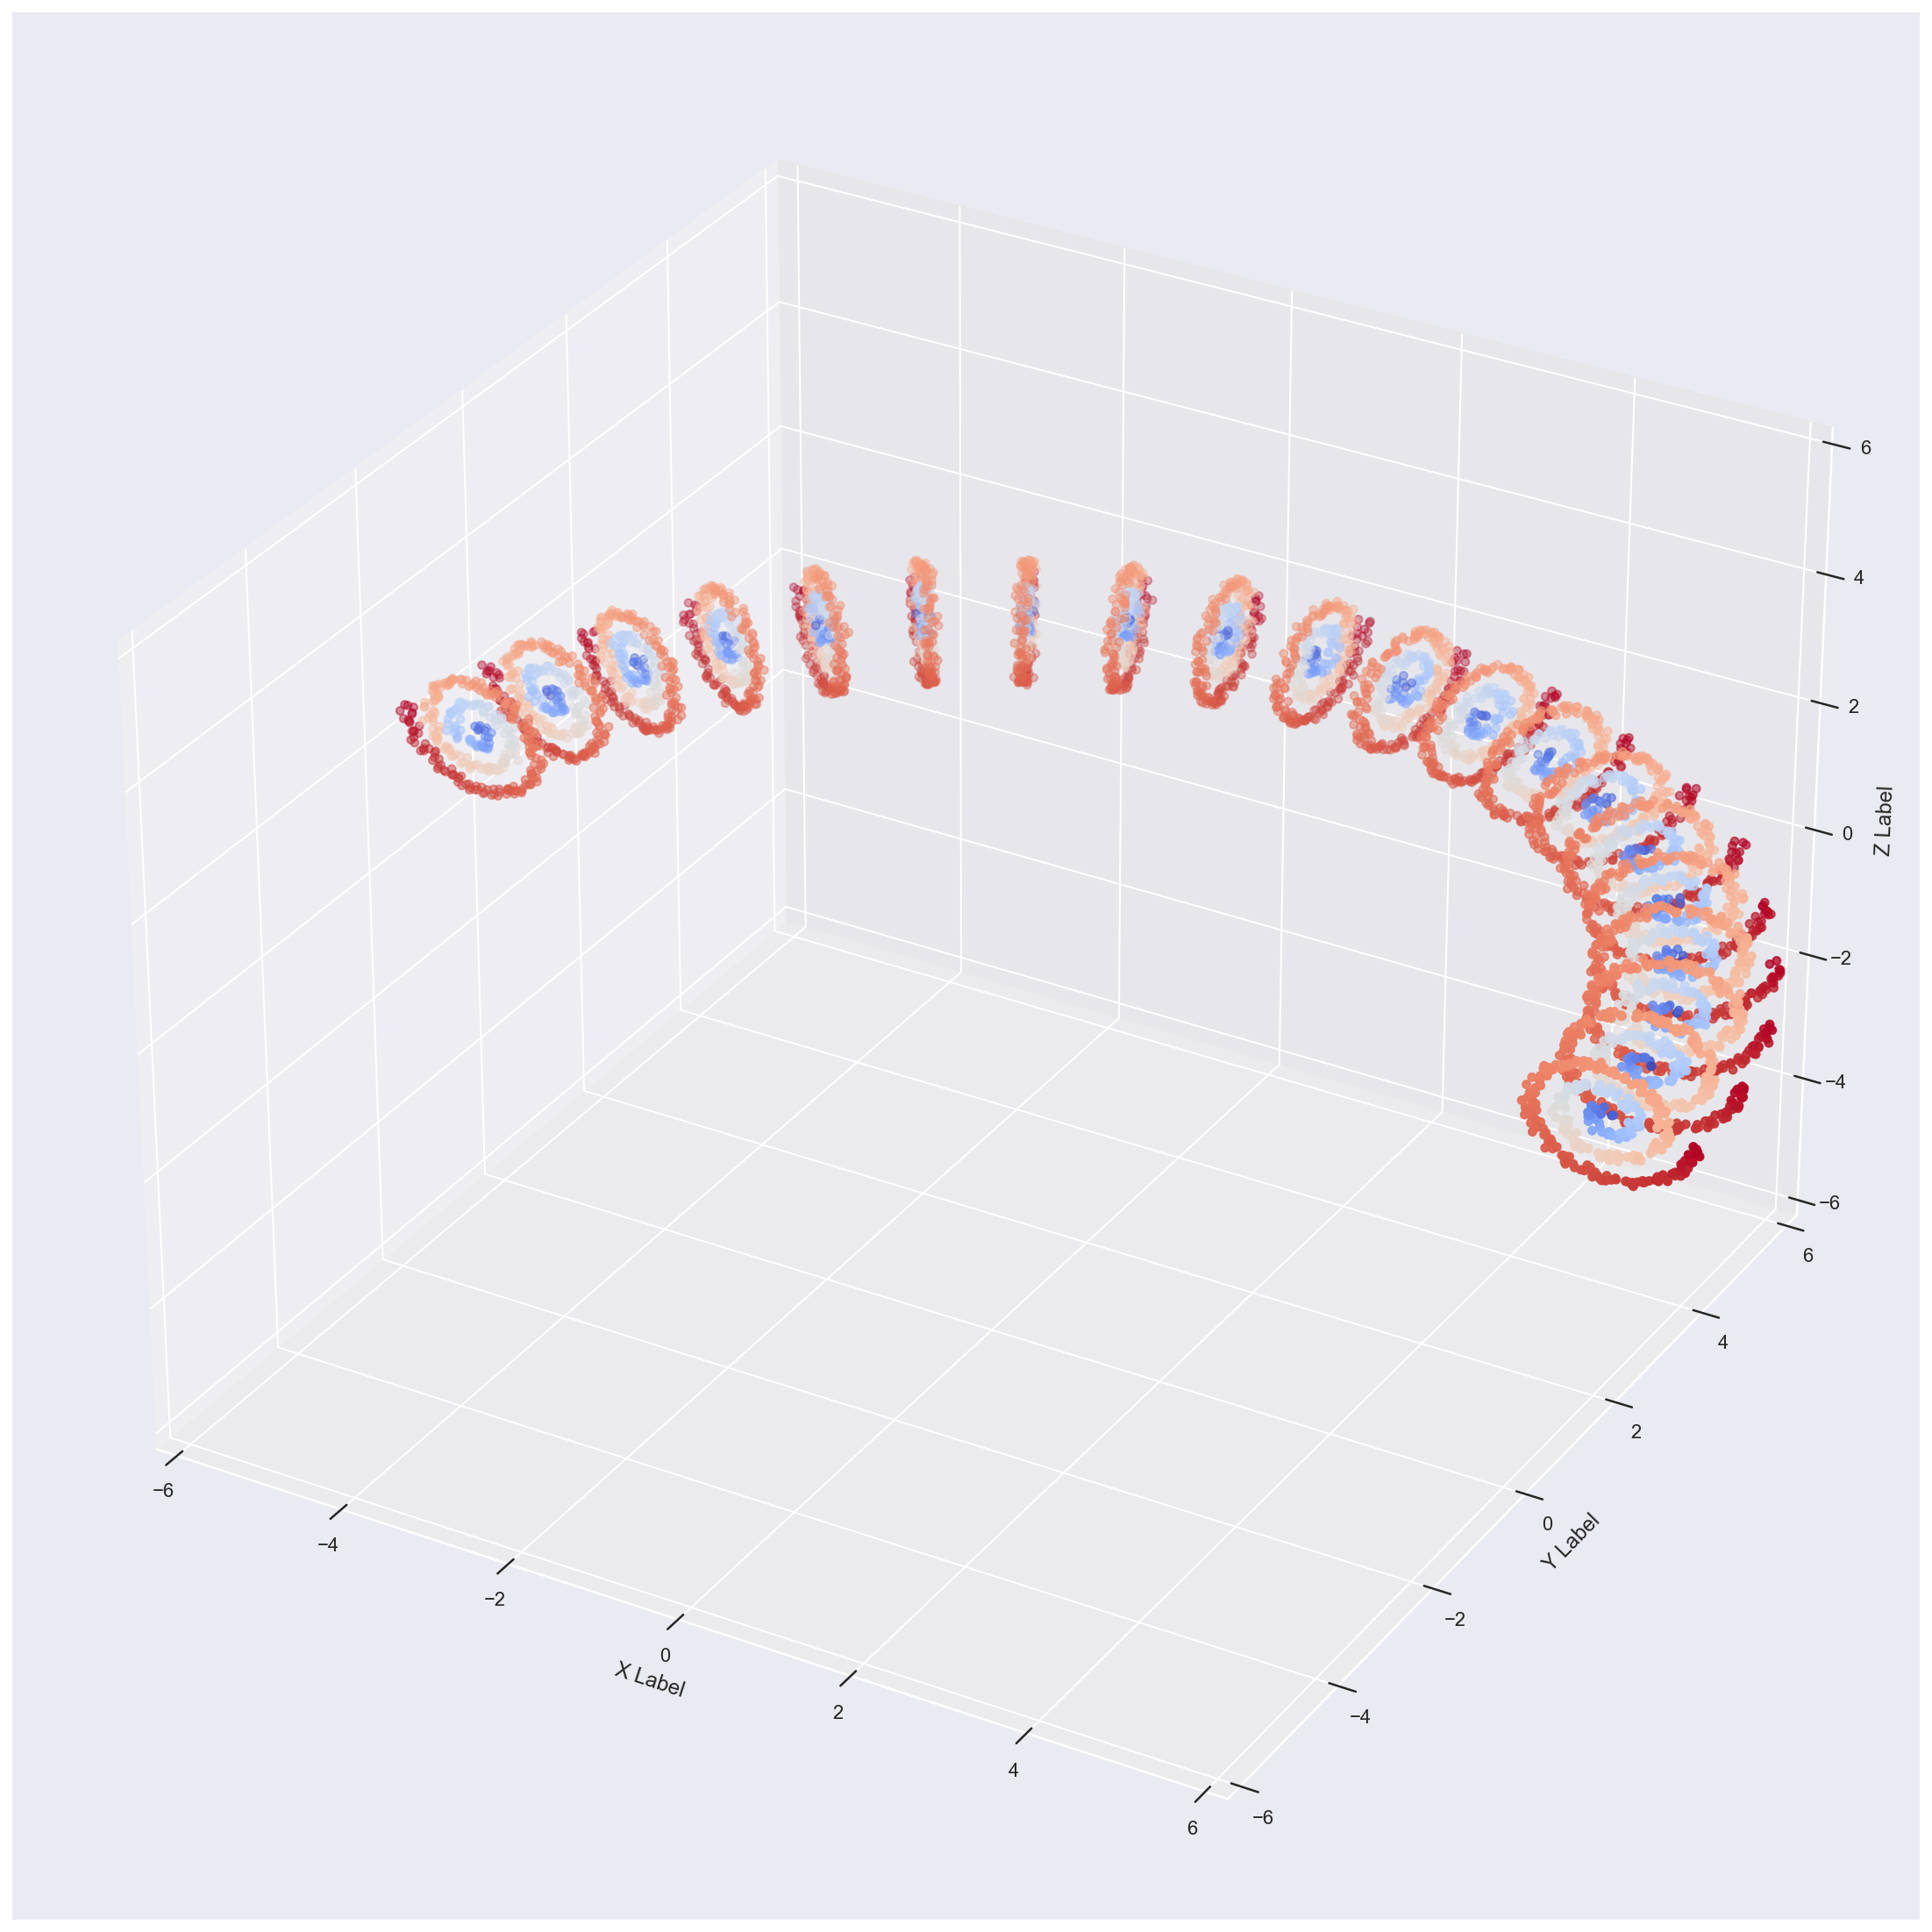

In [6]:
xl, yl = uniform_spiral(density=3, steps=300)
x,y,z,d = uniform_roll(xl,yl, width=7, angle=0.5, density=20, noise_factor=0.15)
plot_roulade(x,y,z,d=d)

### Visualize the prepared set of points by projecting onto a 2D plane, changing the following aspects in subsequent approaches:

1. Density of points generated, in terms of points per spiral

2. Distance between roll layers, layer density

3. Visualization method: PCA, KernelPCA, MDS, t-SNE

4. generate at least a few plots per method


#### Save each generated chart, you will later need it to embeding images

#### PCA implementation

In [7]:
def show_PCA(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5):
    fig = plt.figure()
    x,y,z,d=roll_generator(to_array=False, spiral_density=spiral_density,
                           spiral_steps = spiral_steps, width=width,
                           angle=angle, density=roll_density)
    from mpl_toolkits.mplot3d import Axes3D

    # fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z, c=d, cmap=plt.cm.coolwarm)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.set_zlim([-6, 6])

    ax2 = fig.add_subplot(122)
    points, d=roll_generator(to_array=True, spiral_density=spiral_density,
                           spiral_steps = spiral_steps, width=width,
                           angle=angle, density=roll_density)

    from sklearn.decomposition import PCA
    embedding = PCA(n_components=2)
    points_transformed = embedding.fit_transform(points)
    points_transformed.shape

    points_transformed_t = points_transformed.T
    points_transformed_t.shape

    ax2.scatter(points_transformed_t[0], points_transformed_t[1], c=d, cmap=plt.cm.coolwarm)
    ax2.set_xlabel('X Label')
    ax2.set_ylabel('Y Label')
    
    plt.rcParams["figure.figsize"] = [12, 6]
    
    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'pca_spst{spiral_steps}_roldens{roll_density}_w{width}_a{angle}_sd{spiral_density}.png', bbox_inches=extent)

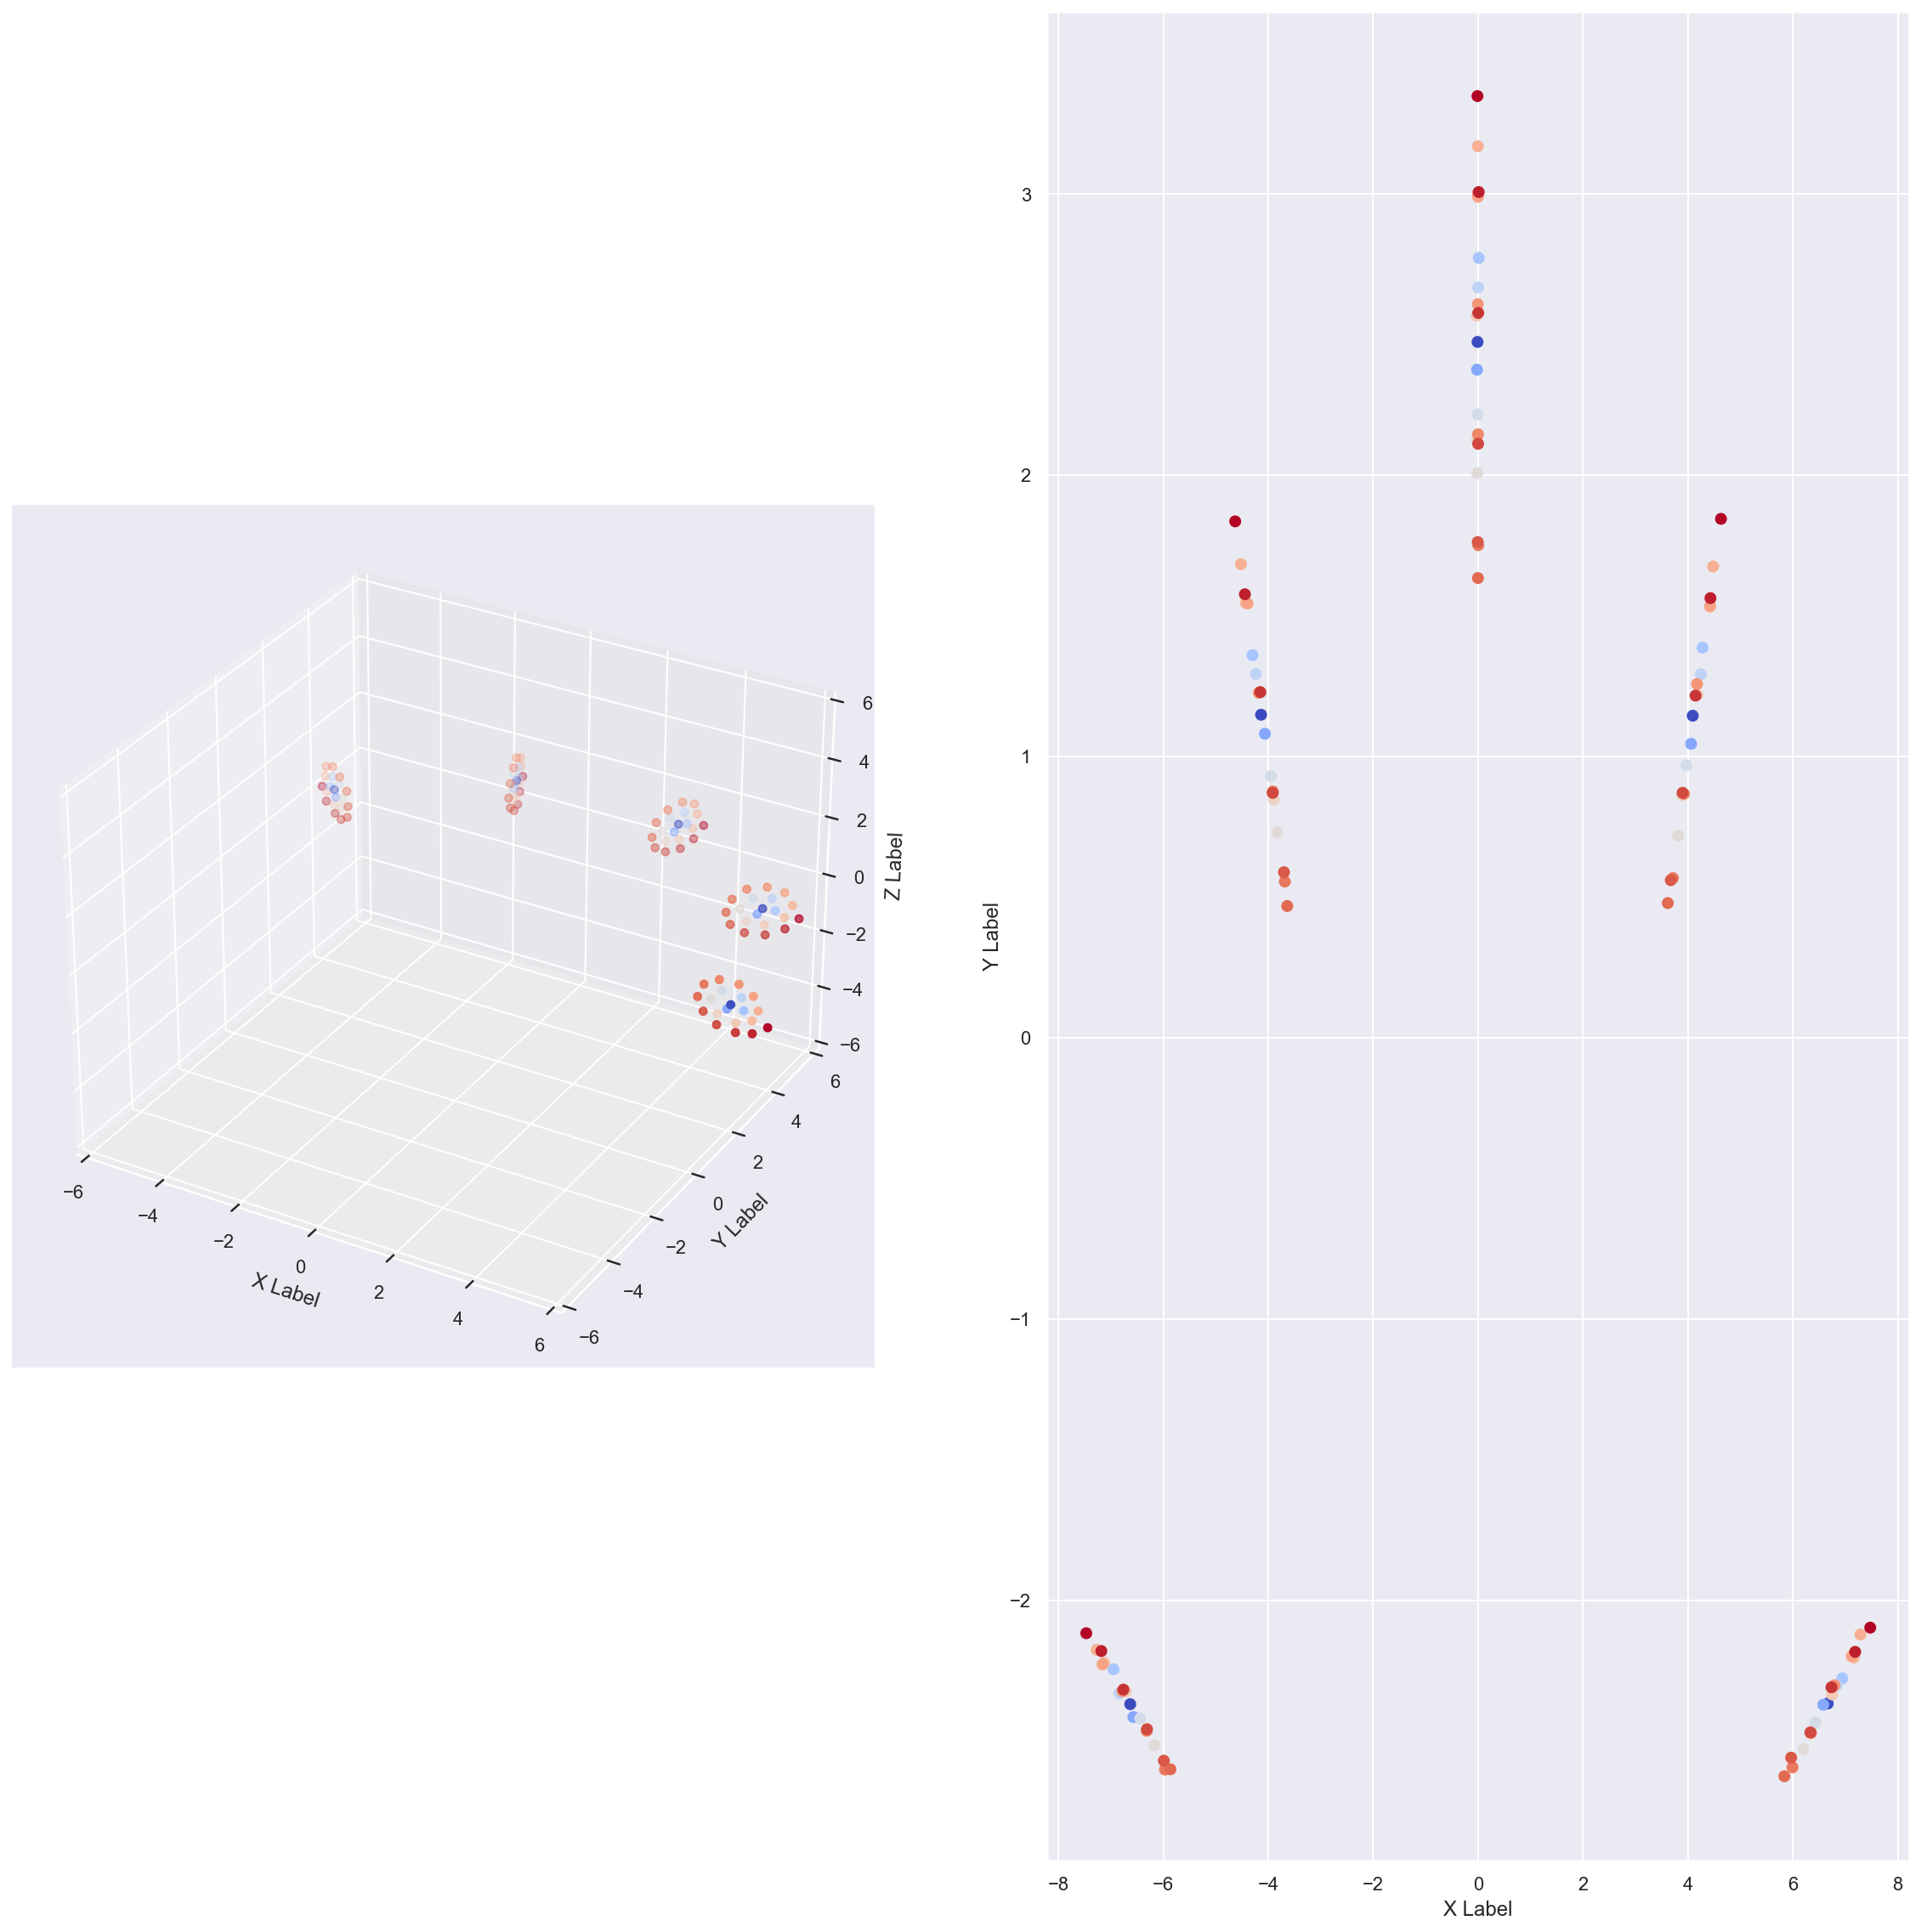

In [8]:
show_PCA(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5)

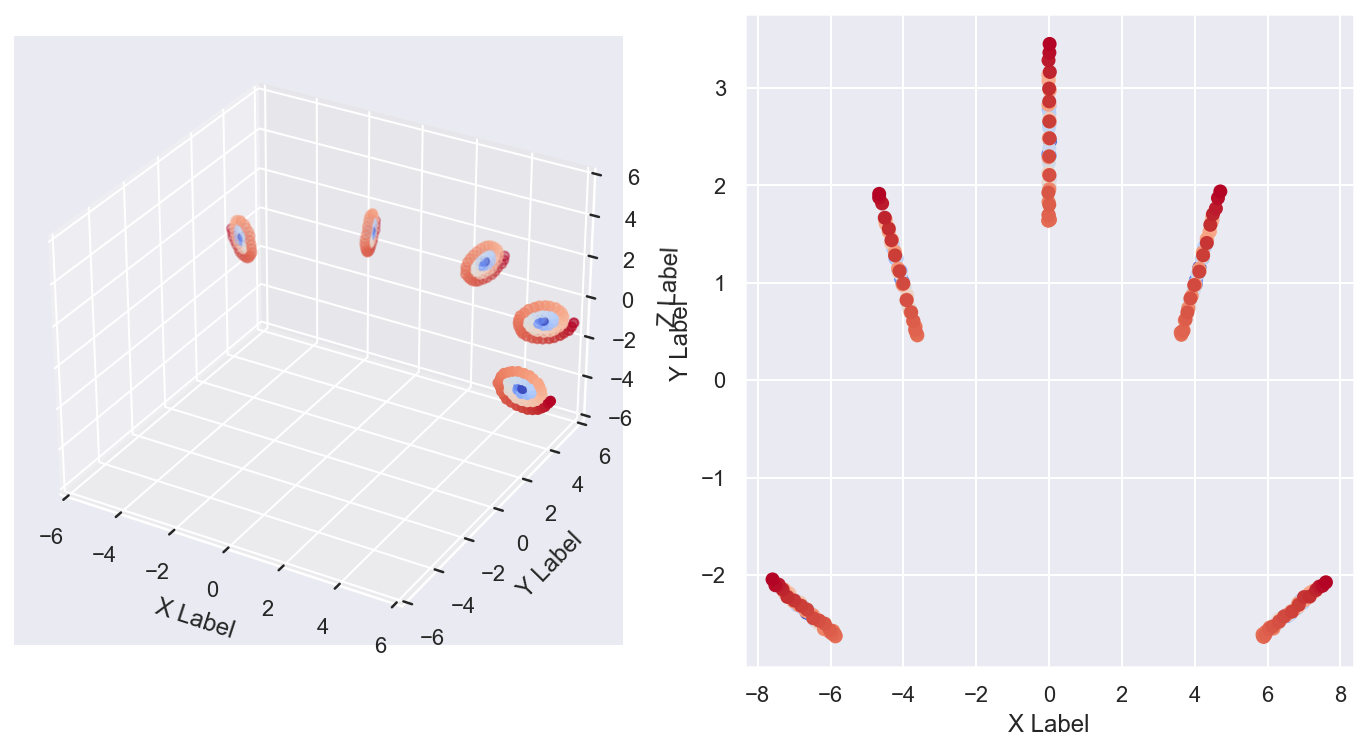

In [9]:
show_PCA(spiral_density=3, spiral_steps = 50, width=7, angle=0.5, roll_density=5)

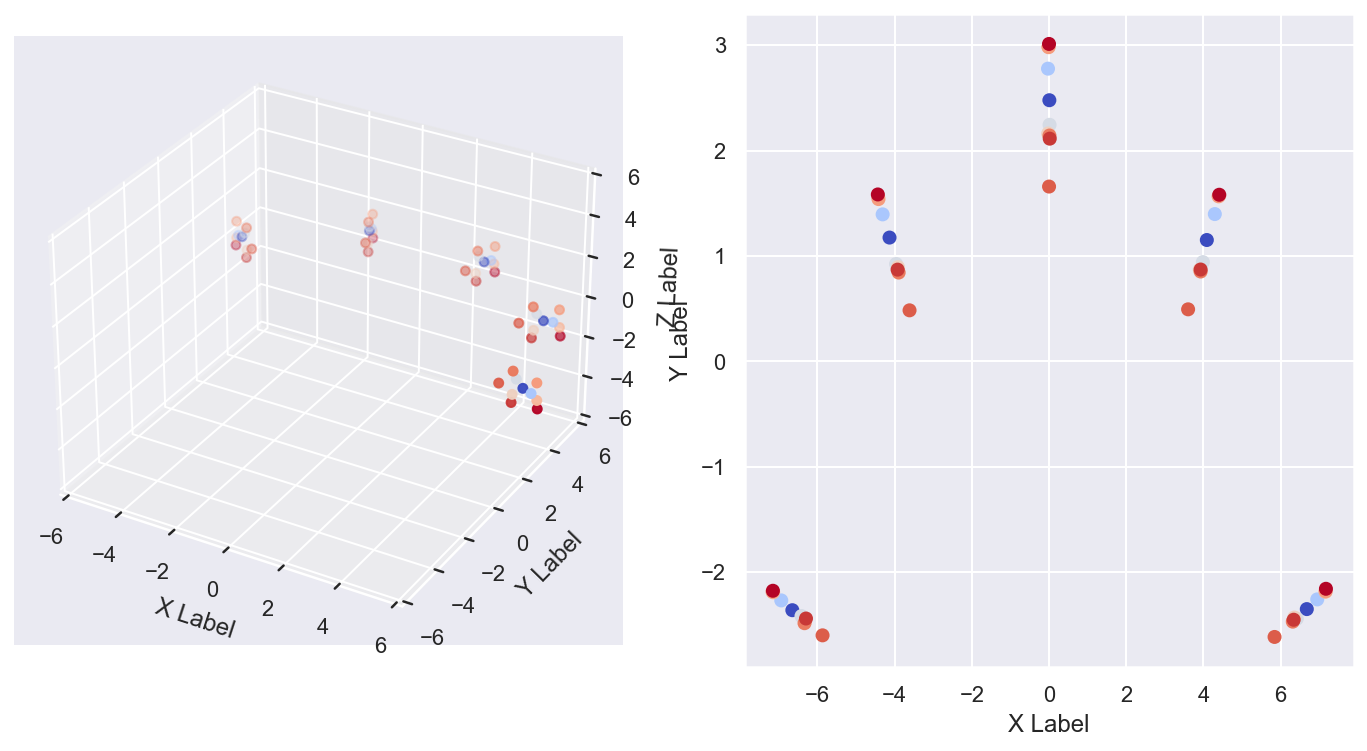

In [10]:
show_PCA(spiral_density=3, spiral_steps = 10, width=7, angle=0.5, roll_density=5)

W przypadku zmieniania ilości punktów w ramach jednej spirali nie zmieniamy kształtu, ani rozmiaru projekcji. Jedyne co zmieniamy to gęstość punktów w ramach wizualizacji pojedynczej spirali w projekcji.

We wszystkich przypadkach kształt wizualizacji to 5 kresek, które wzajemnym położeniem mniej więcej odpowiadają położeniu spiral na pierwotnym obrazie.

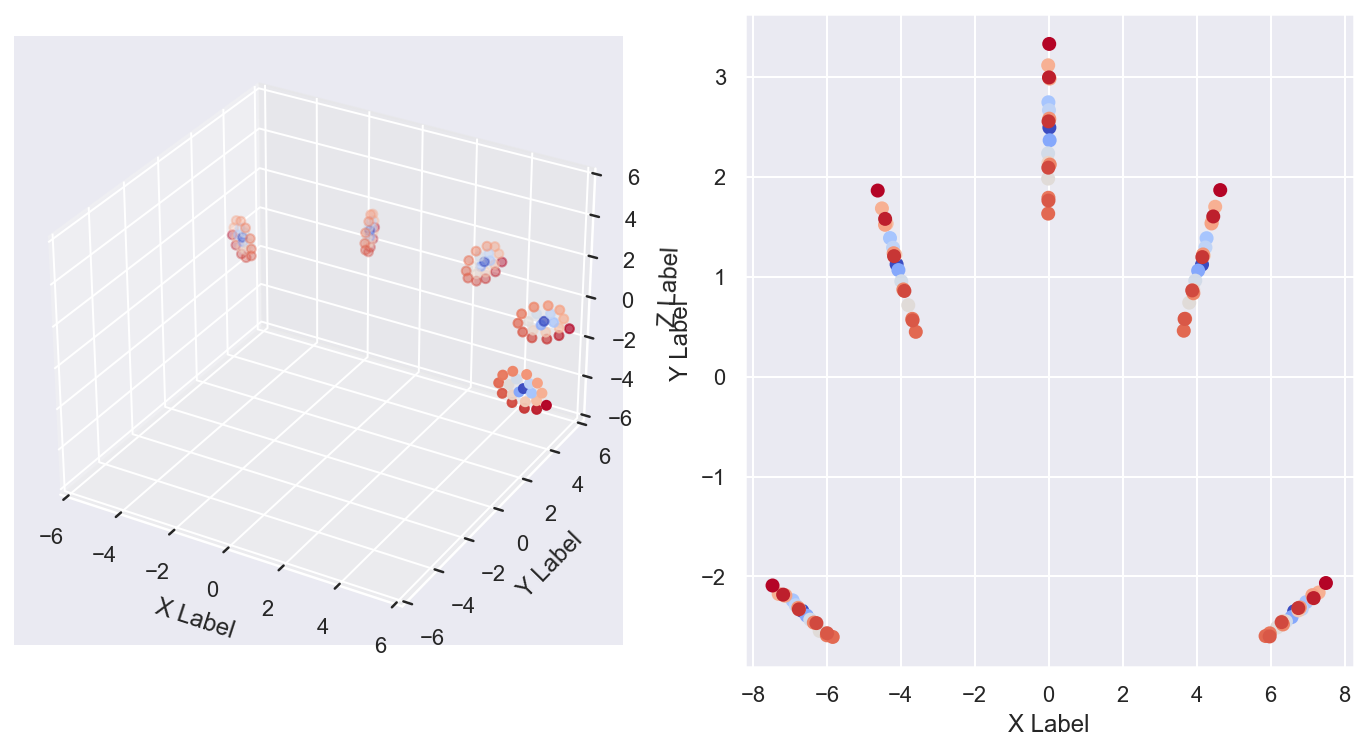

In [11]:
show_PCA(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5)

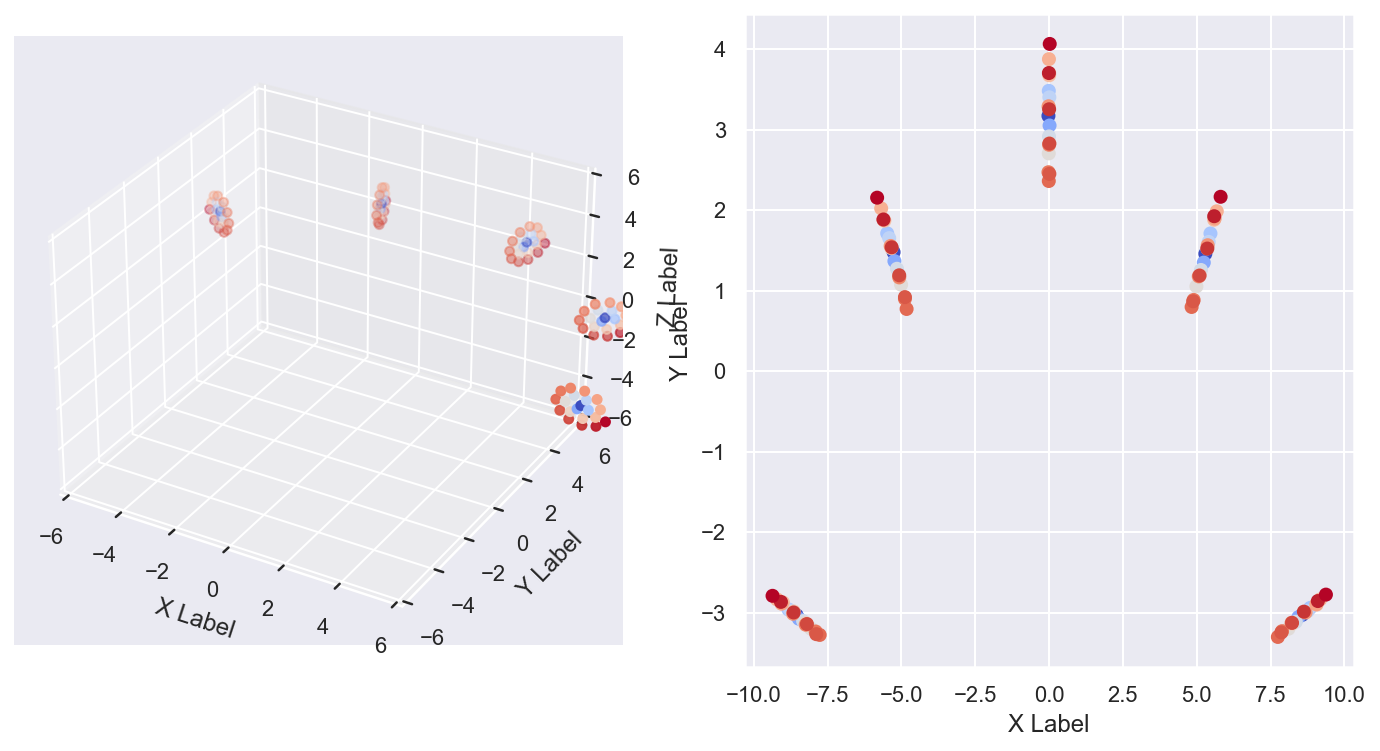

In [12]:
show_PCA(spiral_density=3, spiral_steps = 20, width=9, angle=0.5, roll_density=5)

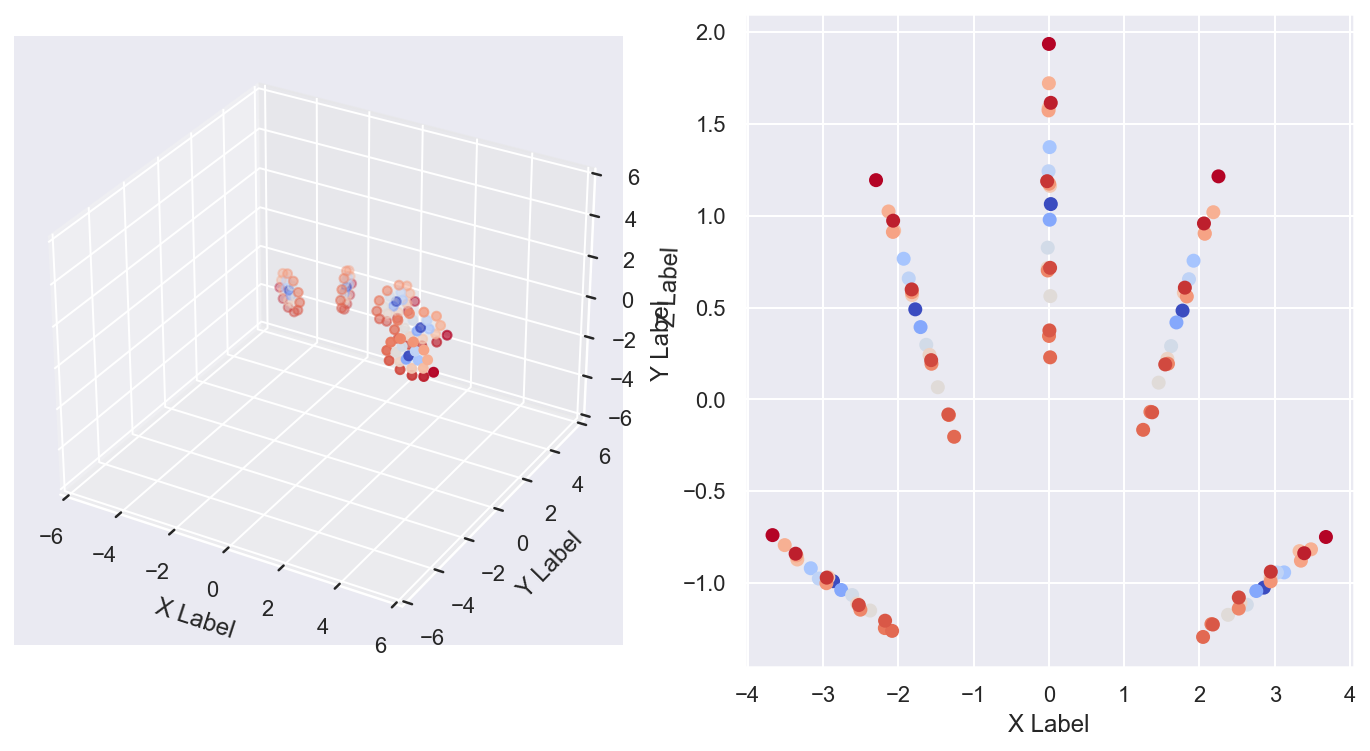

In [13]:
show_PCA(spiral_density=3, spiral_steps = 20, width=3, angle=0.5, roll_density=5)

W przypadku zmiany zagęszczenia spiral nie zmieniamy kształtu projekcji, jednak zmieniamy jej rozmiar. Reprezentacje spiral są bliżej siebie, jeśli na oryginalnym obrazie te spirale były bliżej. Jednoczśnie reprezentacja pojedynczej spirali się nie zmienia, cały czas jest to prosta kreska, co więcej ma ona ten sam rozmiar niezależnie od wzajemnego położenia spiral.


#### KernelPCA implementation

In [14]:
def show_KernelPCA(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5):
    fig = plt.figure()
    x,y,z,d=roll_generator(to_array=False, spiral_density=spiral_density,
                           spiral_steps = spiral_steps, width=width,
                           angle=angle, density=roll_density)
    from mpl_toolkits.mplot3d import Axes3D

    # fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z, c=d, cmap=plt.cm.coolwarm)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.set_zlim([-6, 6])

    ax2 = fig.add_subplot(122)
    points, d=roll_generator(to_array=True, spiral_density=spiral_density,
                           spiral_steps = spiral_steps, width=width,
                           angle=angle, density=roll_density)

    from sklearn.decomposition import KernelPCA
    embedding = KernelPCA(n_components=2)
    points_transformed = embedding.fit_transform(points)
    points_transformed.shape

    points_transformed_t = points_transformed.T
    points_transformed_t.shape

    ax2.scatter(points_transformed_t[0], points_transformed_t[1], c=d, cmap=plt.cm.coolwarm)
    ax2.set_xlabel('X Label')
    ax2.set_ylabel('Y Label')
    
    plt.rcParams["figure.figsize"] = [12, 6]
    
    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'kpca_spst{spiral_steps}_roldens{roll_density}_w{width}_a{angle}_sd{spiral_density}.png', bbox_inches=extent)

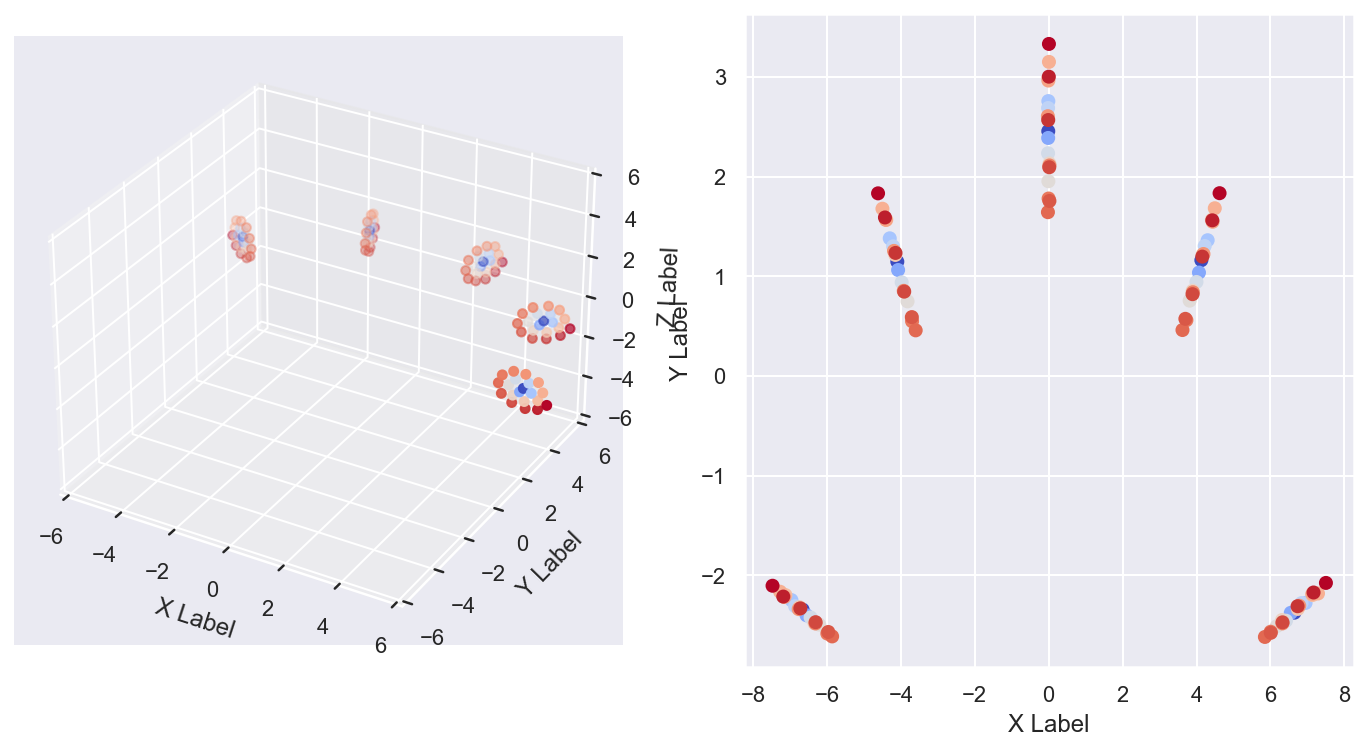

In [15]:
show_KernelPCA(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5)

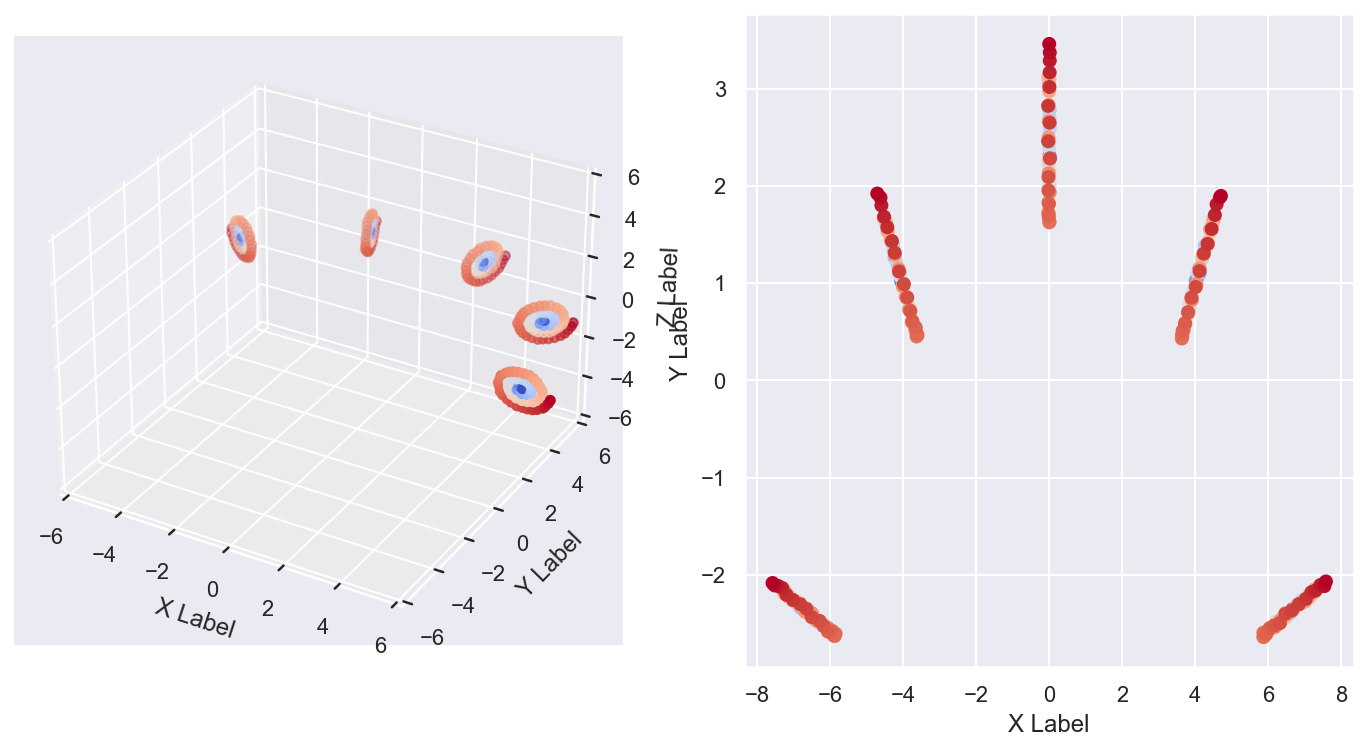

In [16]:
show_KernelPCA(spiral_density=3, spiral_steps = 50, width=7, angle=0.5, roll_density=5)

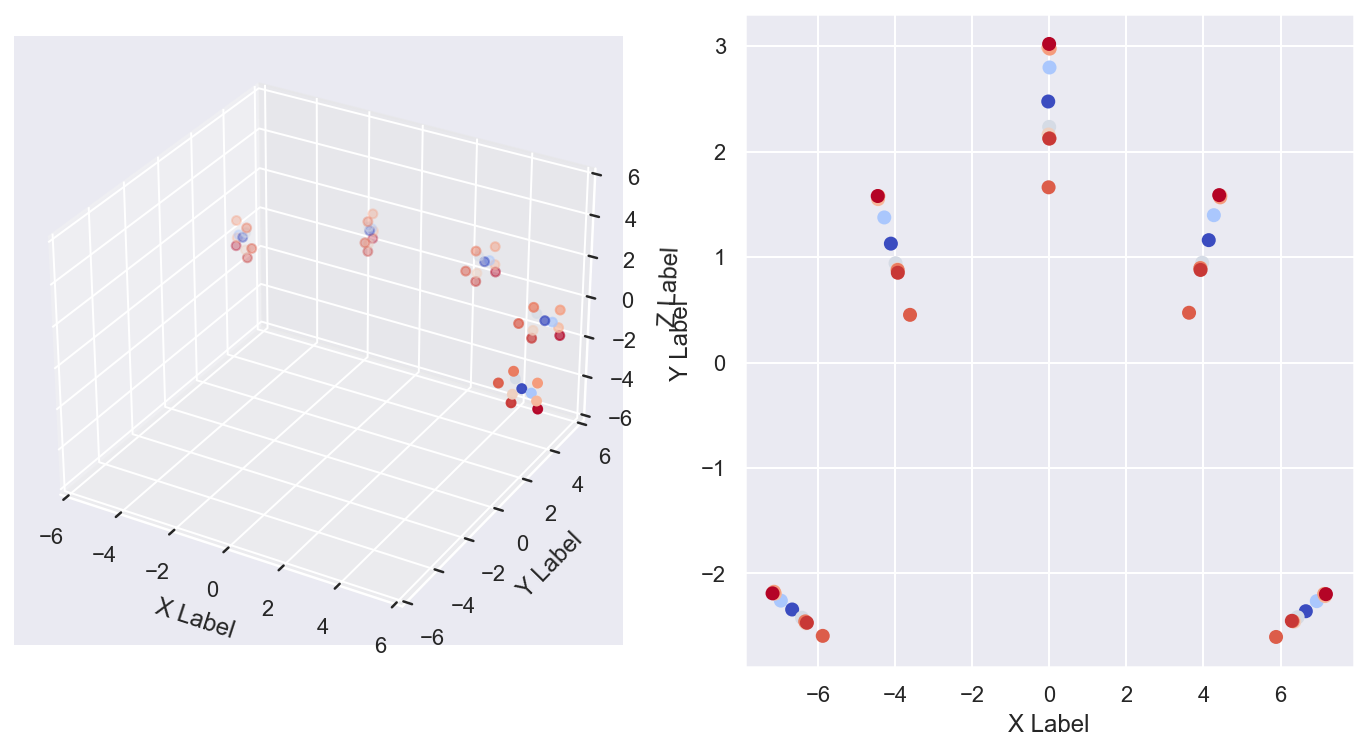

In [17]:
show_KernelPCA(spiral_density=3, spiral_steps = 10, width=7, angle=0.5, roll_density=5)

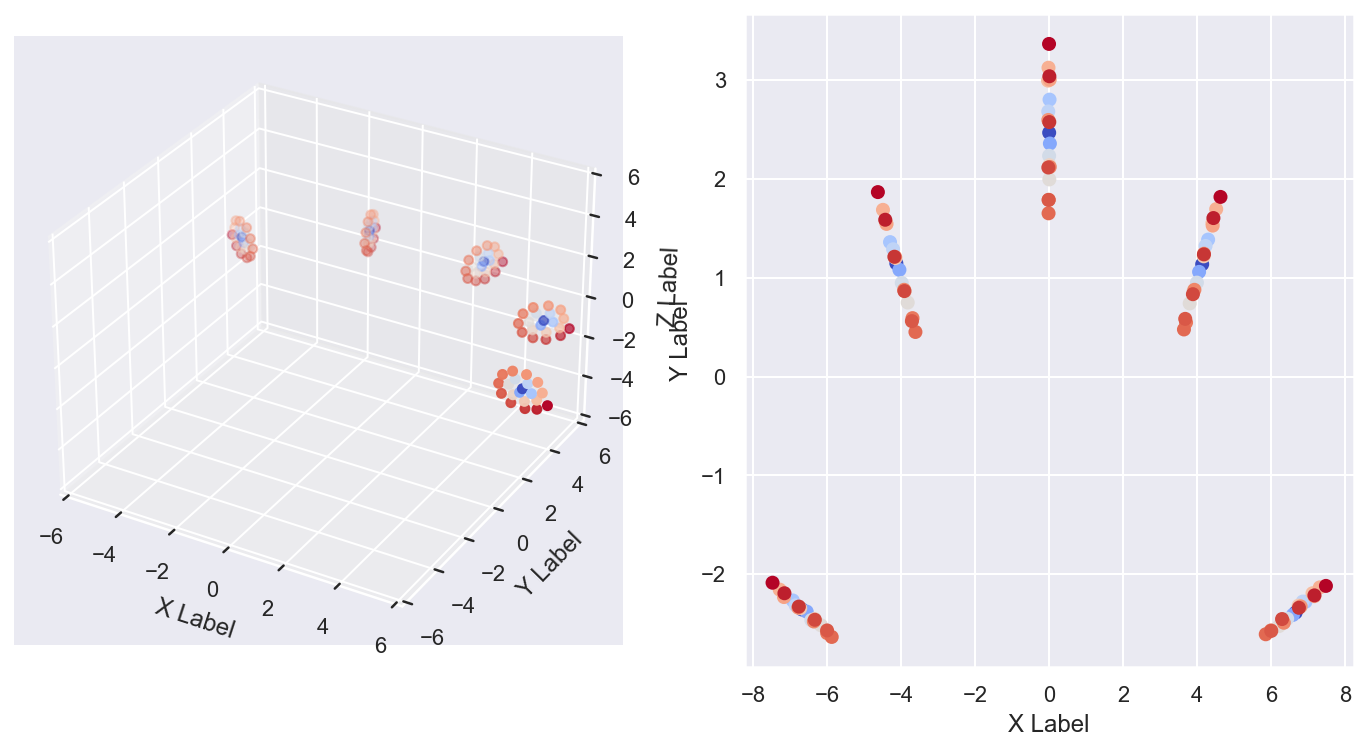

In [18]:
show_KernelPCA(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5)

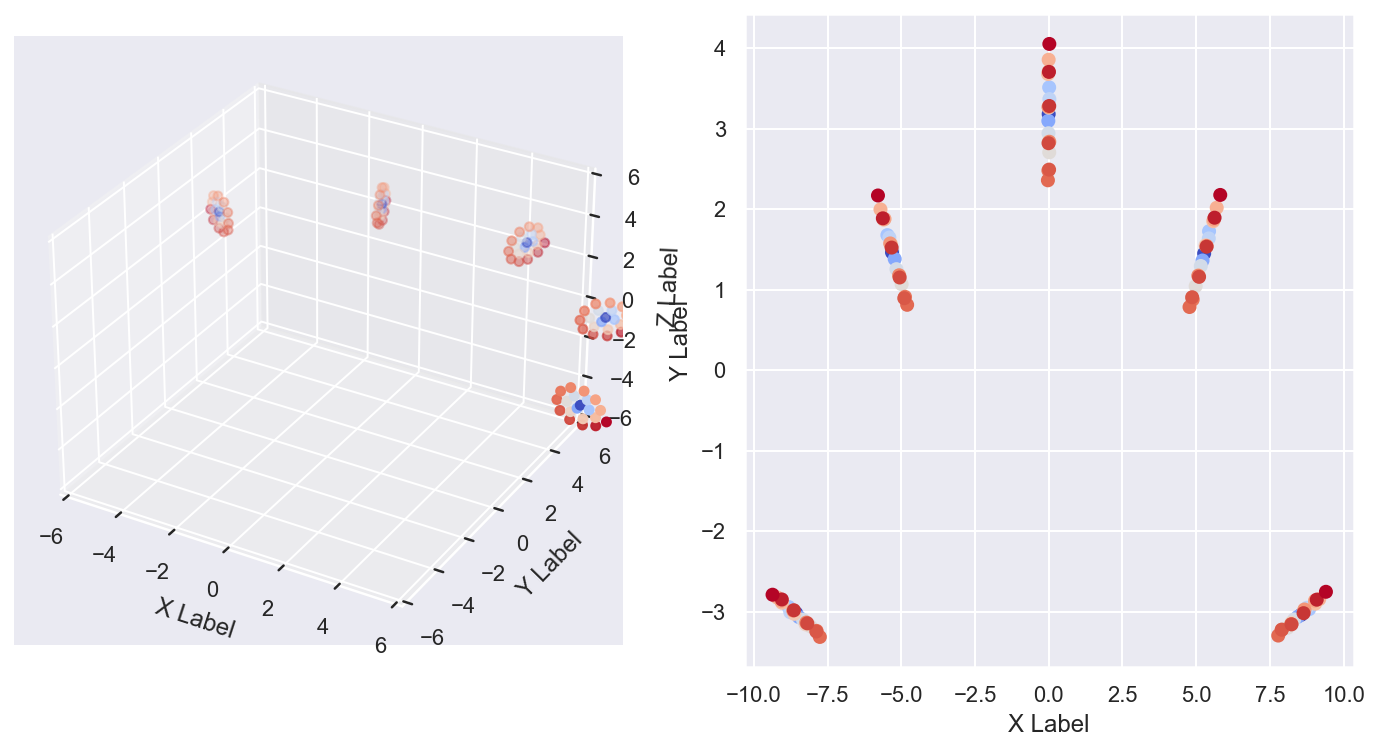

In [19]:
show_KernelPCA(spiral_density=3, spiral_steps = 20, width=9, angle=0.5, roll_density=5)

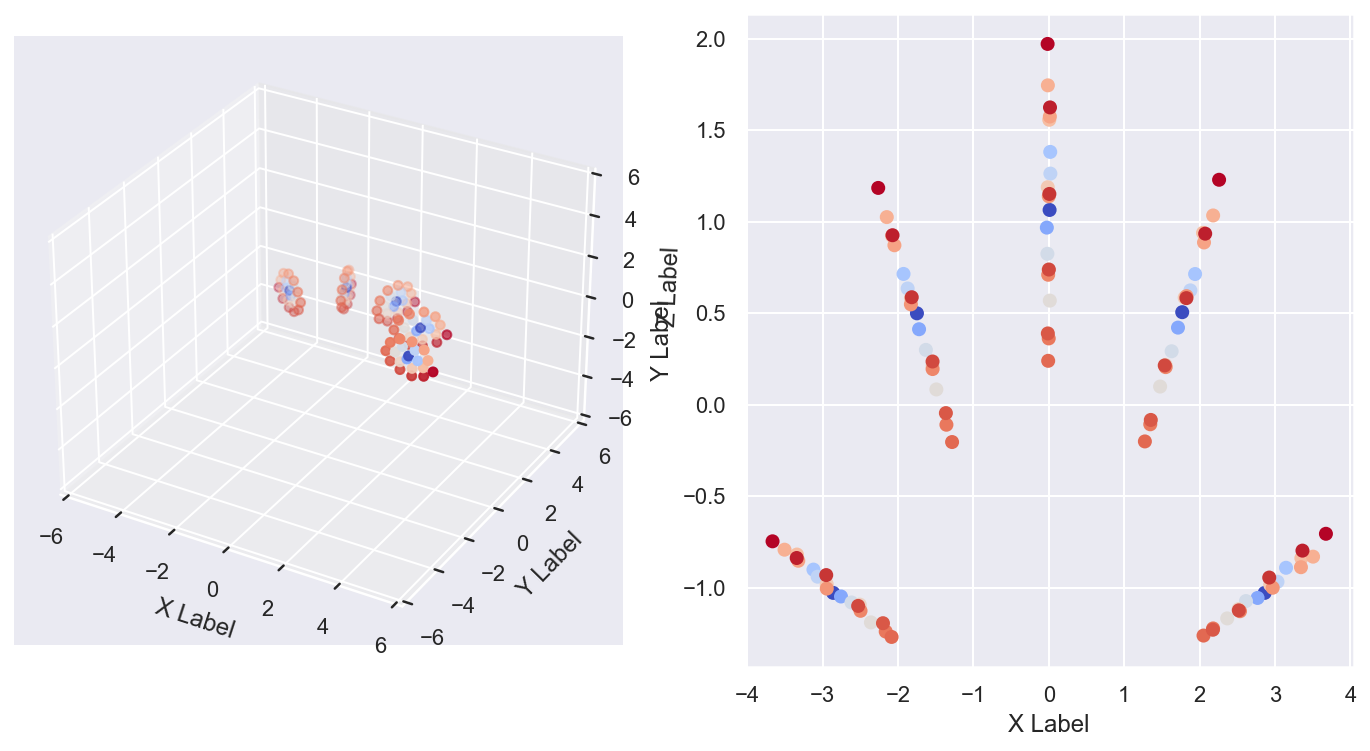

In [20]:
show_KernelPCA(spiral_density=3, spiral_steps = 20, width=3, angle=0.5, roll_density=5)

Dla kernel PCA wyniki są niemal identyczne co wyniki dla zwykłego PCA uruchamianego z tymi samymi parametrami. Wynika to z użycia kernela liniowego.

#### MDE implementation

In [21]:
def show_MDE(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5):
    fig = plt.figure()
    x,y,z,d=roll_generator(to_array=False, spiral_density=spiral_density,
                           spiral_steps = spiral_steps, width=width,
                           angle=angle, density=roll_density)
    from mpl_toolkits.mplot3d import Axes3D

    # fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z, c=d, cmap=plt.cm.coolwarm)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.set_zlim([-6, 6])

    ax2 = fig.add_subplot(122)
    points, d=roll_generator(to_array=True, spiral_density=spiral_density,
                           spiral_steps = spiral_steps, width=width,
                           angle=angle, density=roll_density)

    from sklearn.manifold import MDS
    embedding = MDS(n_components=2)
    points_transformed = embedding.fit_transform(points)
    points_transformed.shape

    points_transformed_t = points_transformed.T
    points_transformed_t.shape

    ax2.scatter(points_transformed_t[0], points_transformed_t[1], c=d, cmap=plt.cm.coolwarm)
    ax2.set_xlabel('X Label')
    ax2.set_ylabel('Y Label')
    
    plt.rcParams["figure.figsize"] = [12, 6]
    
    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'mde_spst{spiral_steps}_roldens{roll_density}_w{width}_a{angle}_sd{spiral_density}.png', bbox_inches=extent)

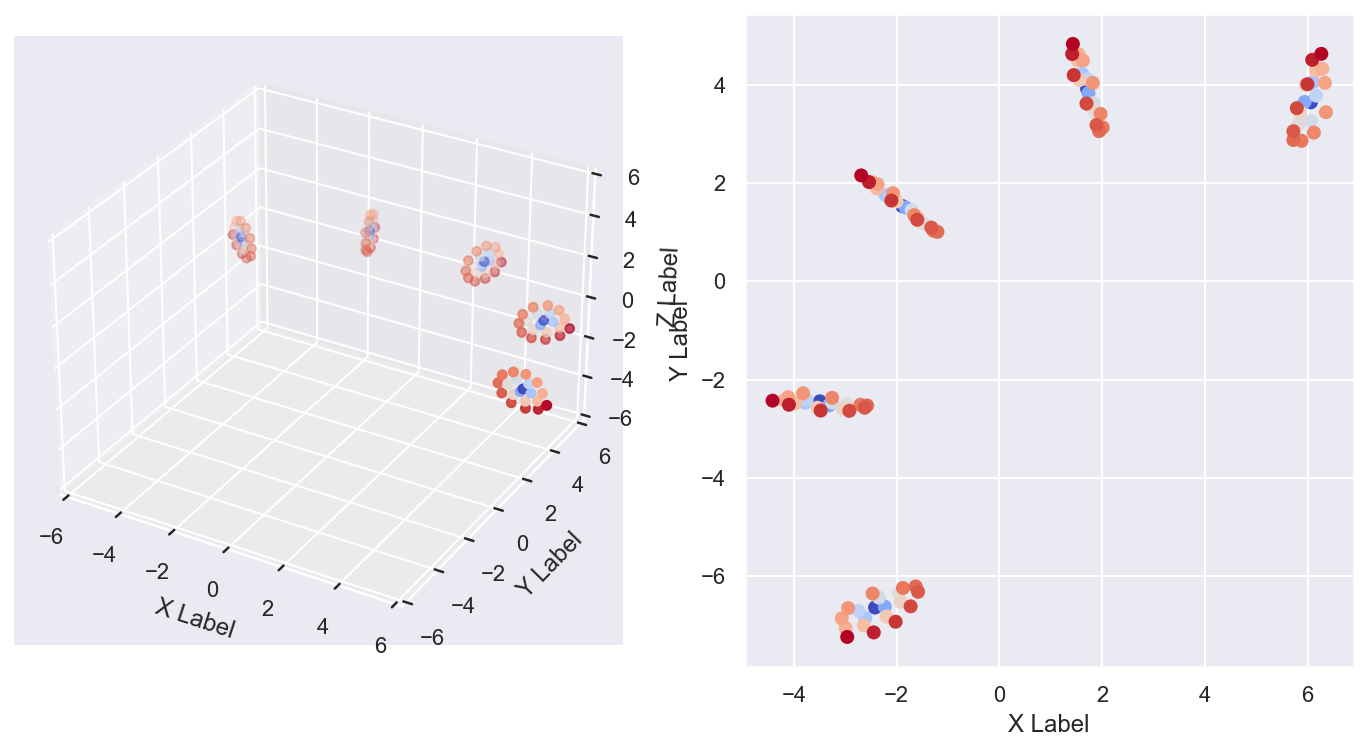

In [22]:
show_MDE(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5)

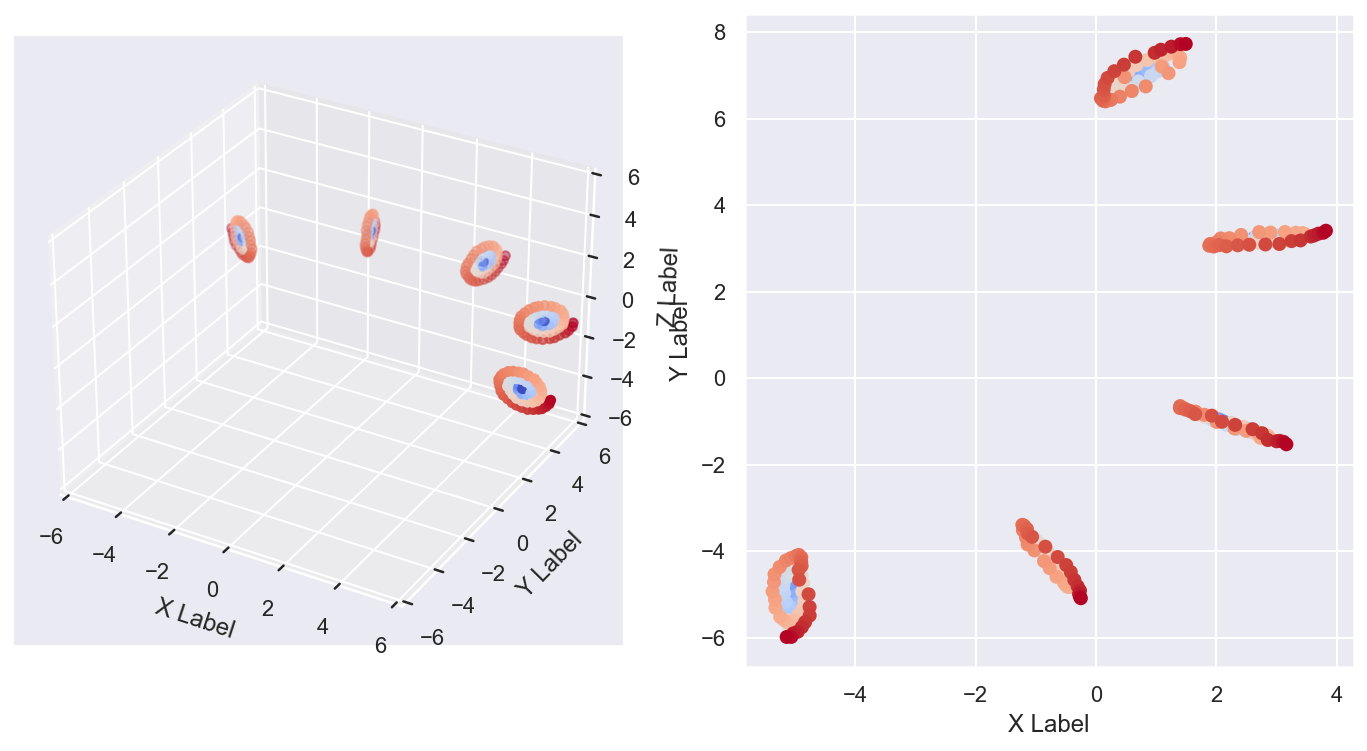

In [23]:
show_MDE(spiral_density=3, spiral_steps = 50, width=7, angle=0.5, roll_density=5)

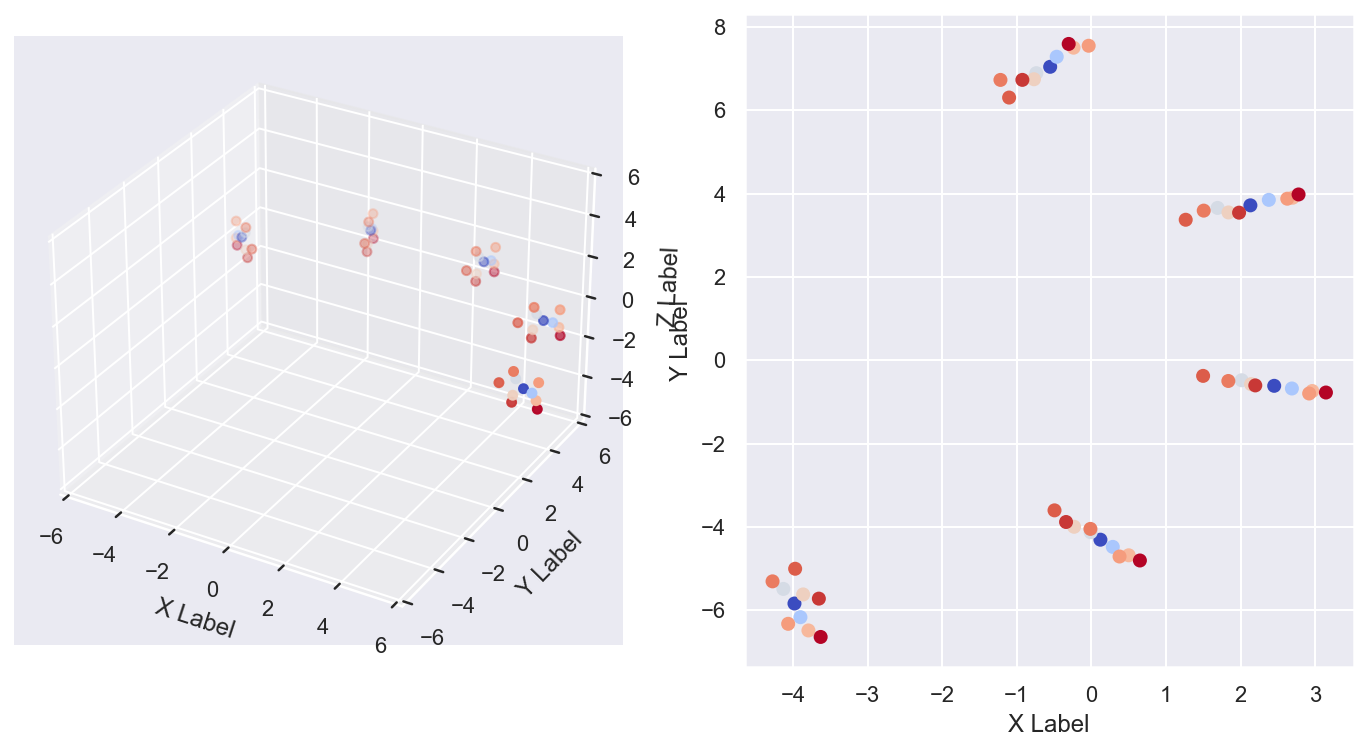

In [24]:
show_MDE(spiral_density=3, spiral_steps = 10, width=7, angle=0.5, roll_density=5)

Metoda MDS daje trochę inne wyniki niż poprzednie metody. Po pierwsze, dwuwymiarowa reprezentacja spiral nie jest płaską linią, lecz przypomina coś w rodzaju spirali. Szczególnie spirale "na krańcach" lepiej oddają swój pierwotny kształt. Po drugie, choć reprezentacje spiral nadal są wobec siebie ustawione "pod kątem", to ten kąt jest trochę mniejszy.

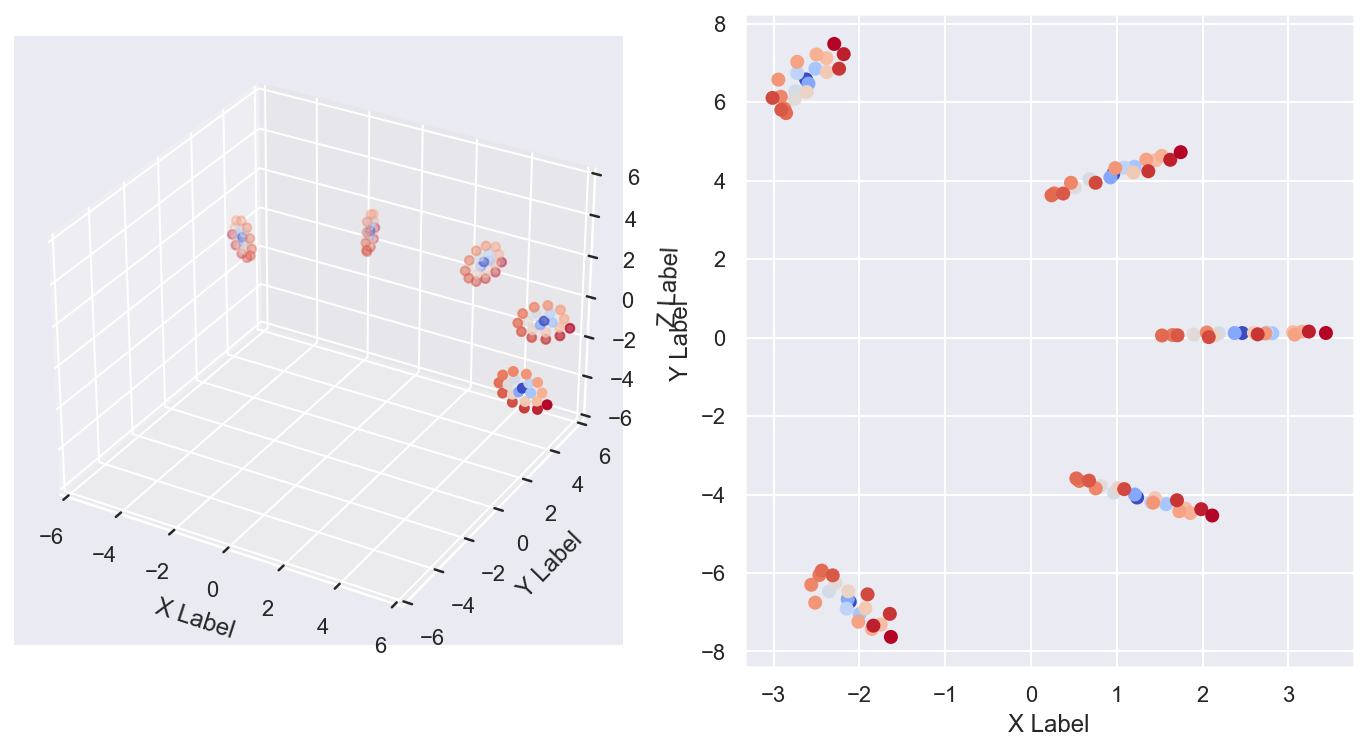

In [25]:
show_MDE(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5)

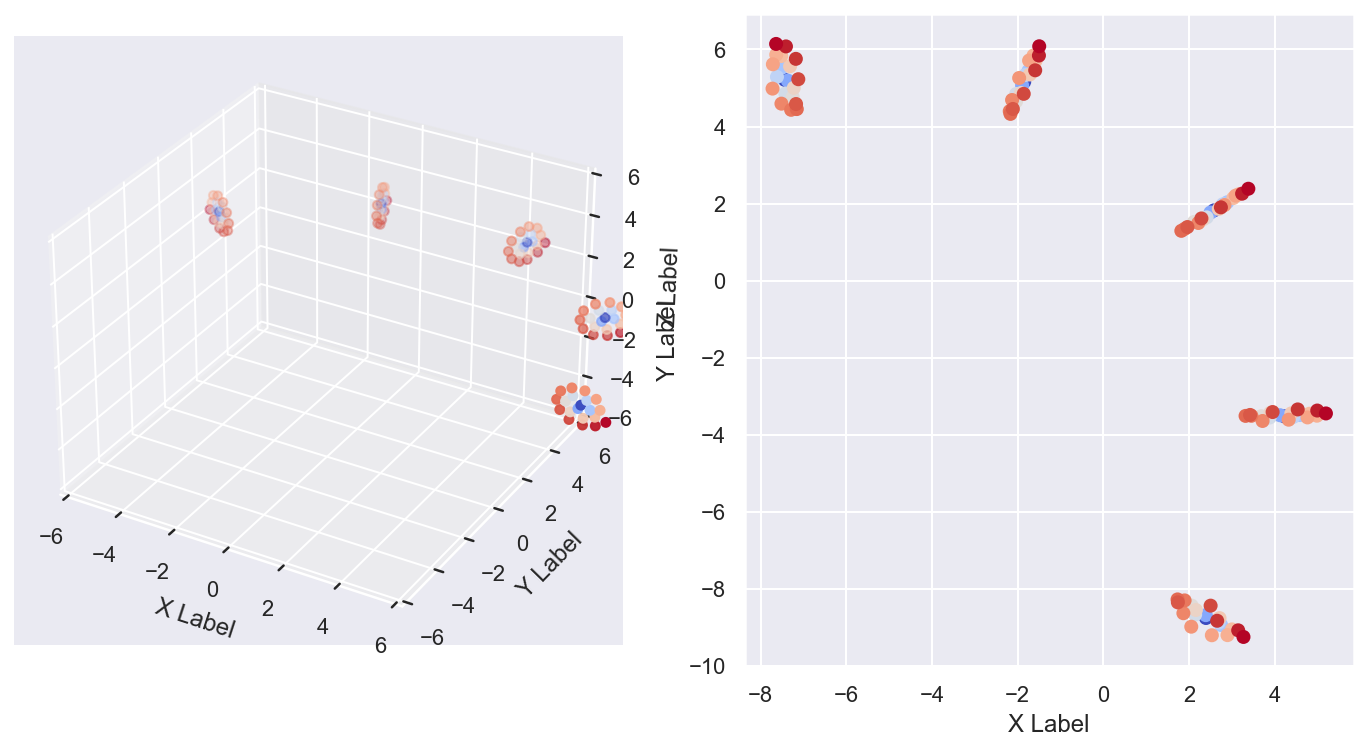

In [26]:
show_MDE(spiral_density=3, spiral_steps = 20, width=9, angle=0.5, roll_density=5)

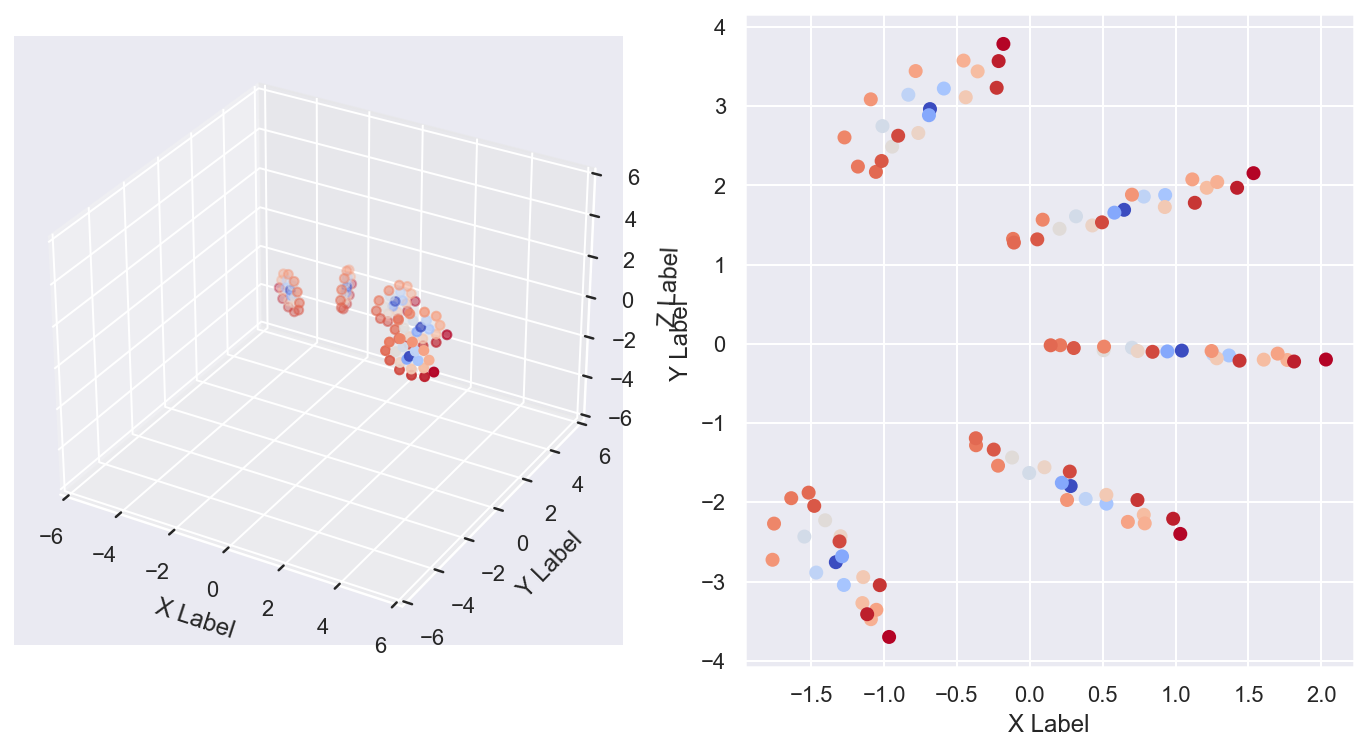

In [27]:
show_MDE(spiral_density=3, spiral_steps = 20, width=3, angle=0.5, roll_density=5)

Zmiana wzajemnego położenia spiral zmienia też wzajemne położenie projekcji (jeśli na pierwotnym obrazie są bliżej, to na projekcji też są bliżej). Jednocześnie jednak rozmiary samych reprezentacji spiral nie zmienia się.

#### t-SNE implementation

In [28]:

def show_tSNE(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5, n_neighbors=5,
              metric='euclidean', perplexity=30):
    fig = plt.figure()
    x,y,z,d=roll_generator(to_array=False, spiral_density=spiral_density,
                           spiral_steps = spiral_steps, width=width,
                           angle=angle, density=roll_density)
    from mpl_toolkits.mplot3d import Axes3D

    # fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z, c=d, cmap=plt.cm.coolwarm)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.set_zlim([-6, 6])

    ax2 = fig.add_subplot(122)
    points, d=roll_generator(to_array=True, spiral_density=spiral_density,
                           spiral_steps = spiral_steps, width=width,
                           angle=angle, density=roll_density)

    from sklearn.manifold import TSNE
    points_transformed = TSNE(n_components=2, metric=metric, perplexity=perplexity).fit_transform(points)
    
    points_transformed_t = points_transformed.T


    ax2.scatter(points_transformed_t[0], points_transformed_t[1], c=d, cmap=plt.cm.coolwarm)
    ax2.set_xlabel('X Label')
    ax2.set_ylabel('Y Label')
    
    plt.rcParams["figure.figsize"] = [12, 6]
    
    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'tsne_n{n_neighbors}_spst{spiral_steps}_roldens{roll_density}_w{width}_a{angle}_sd{spiral_density}.png', bbox_inches=extent)

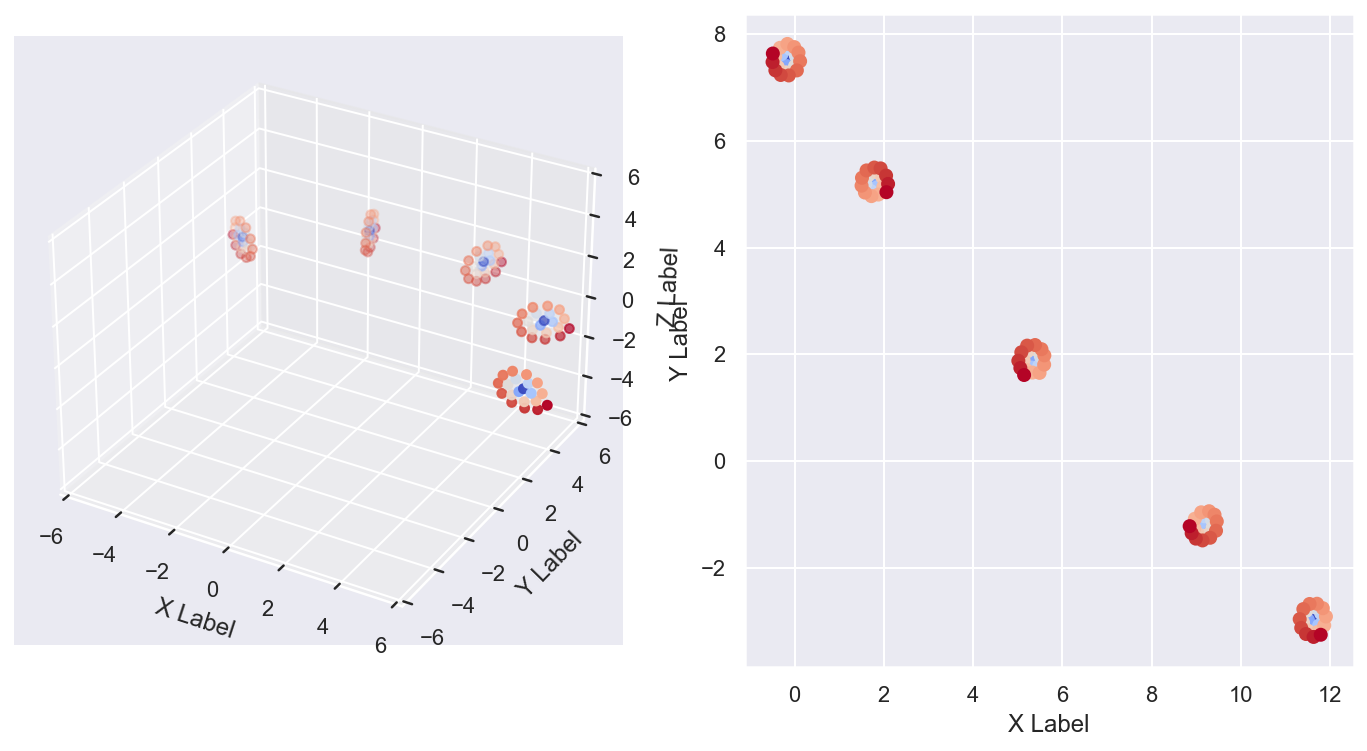

In [30]:
show_tSNE(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5, n_neighbors=5,
              metric='euclidean', perplexity=30)

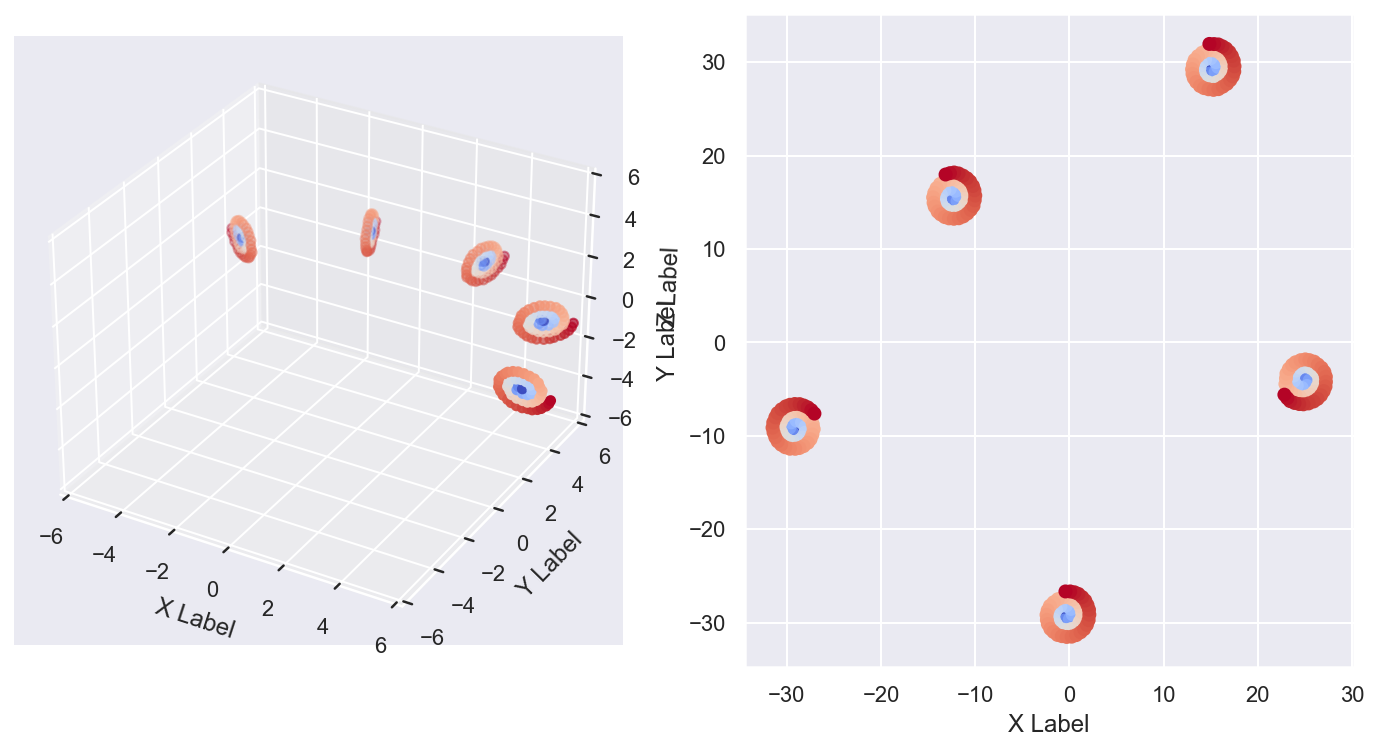

In [31]:
show_tSNE(spiral_density=3, spiral_steps = 50, width=7, angle=0.5, roll_density=5, n_neighbors=5,
              metric='euclidean', perplexity=30)

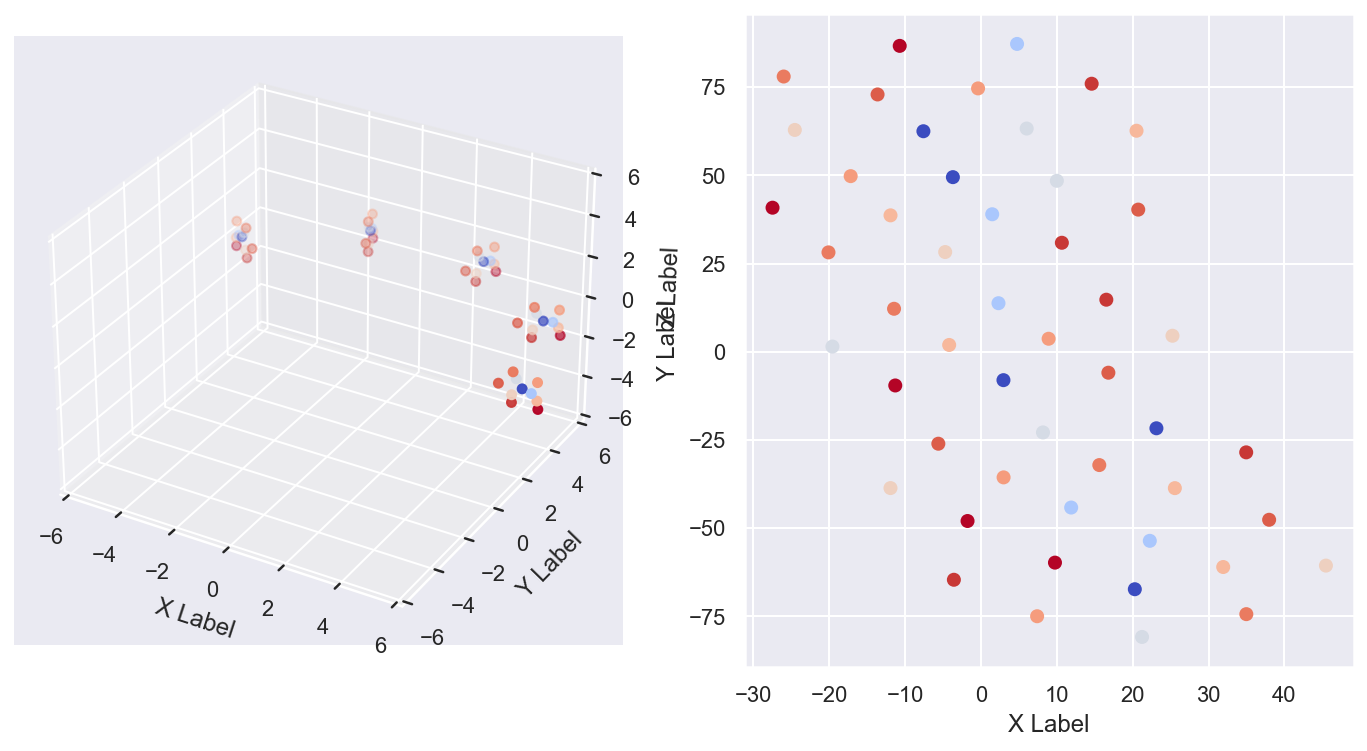

In [32]:
show_tSNE(spiral_density=3, spiral_steps = 10, width=7, angle=0.5, roll_density=5, n_neighbors=5,
              metric='euclidean', perplexity=30)

W odróżnieniu od pozostałych metod, w przypadku metody tSNE zmiana gęstości spirali całkowicie zmieniła wzajemne rozmieszczenie spiral. Po pierwsze, można zauważyć, że reprezentacje spiral nie są już liniami, lecz mają okrągły kształt. Po drugie zmiana gęstości zmienia całkowicie wzajemne położenie spiral. W pierszym przykładzie (20 punktów na spiralę) spirale są ustawione w linii. W drugim (50 punktów na spiralę) - formują coś na kształt okręgu. W trzecim - w ogóle nie można już rozróżnić pierwotnych spiral.

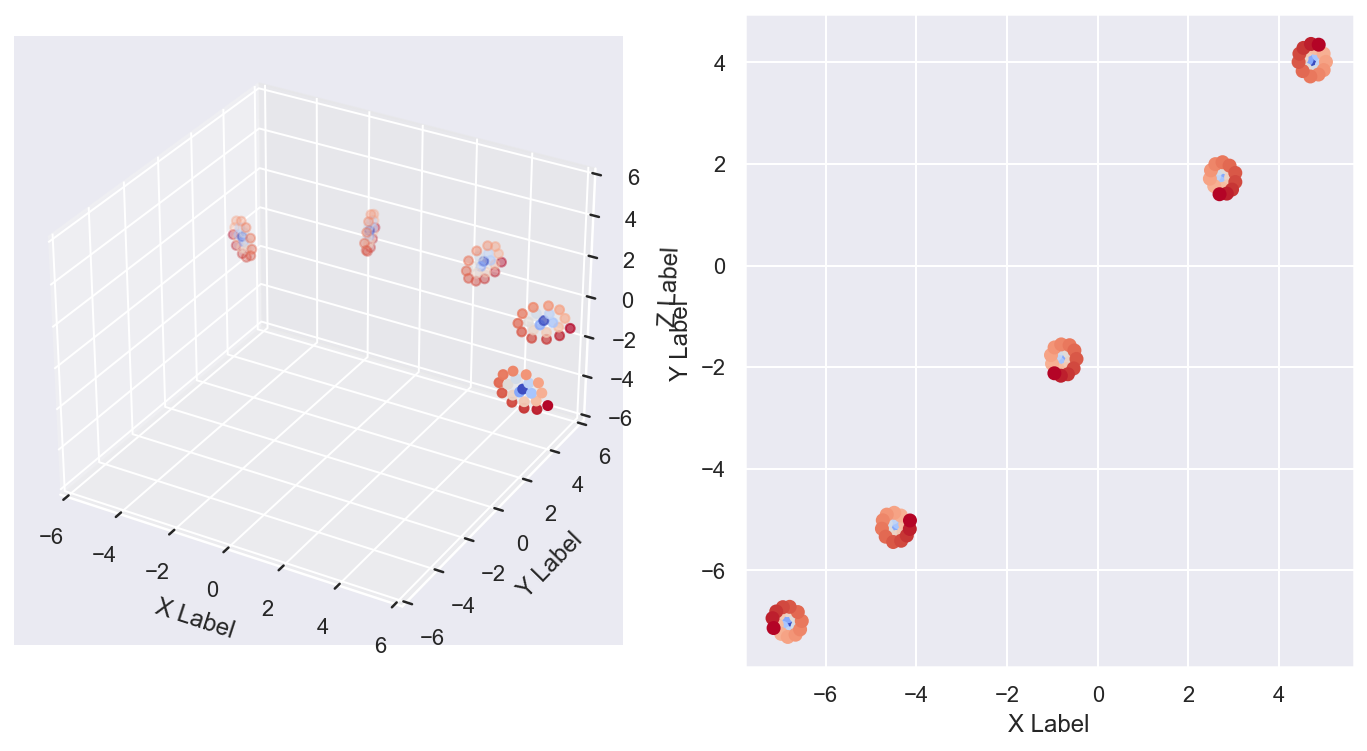

In [33]:
show_tSNE(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5, n_neighbors=5,
              metric='euclidean', perplexity=30)

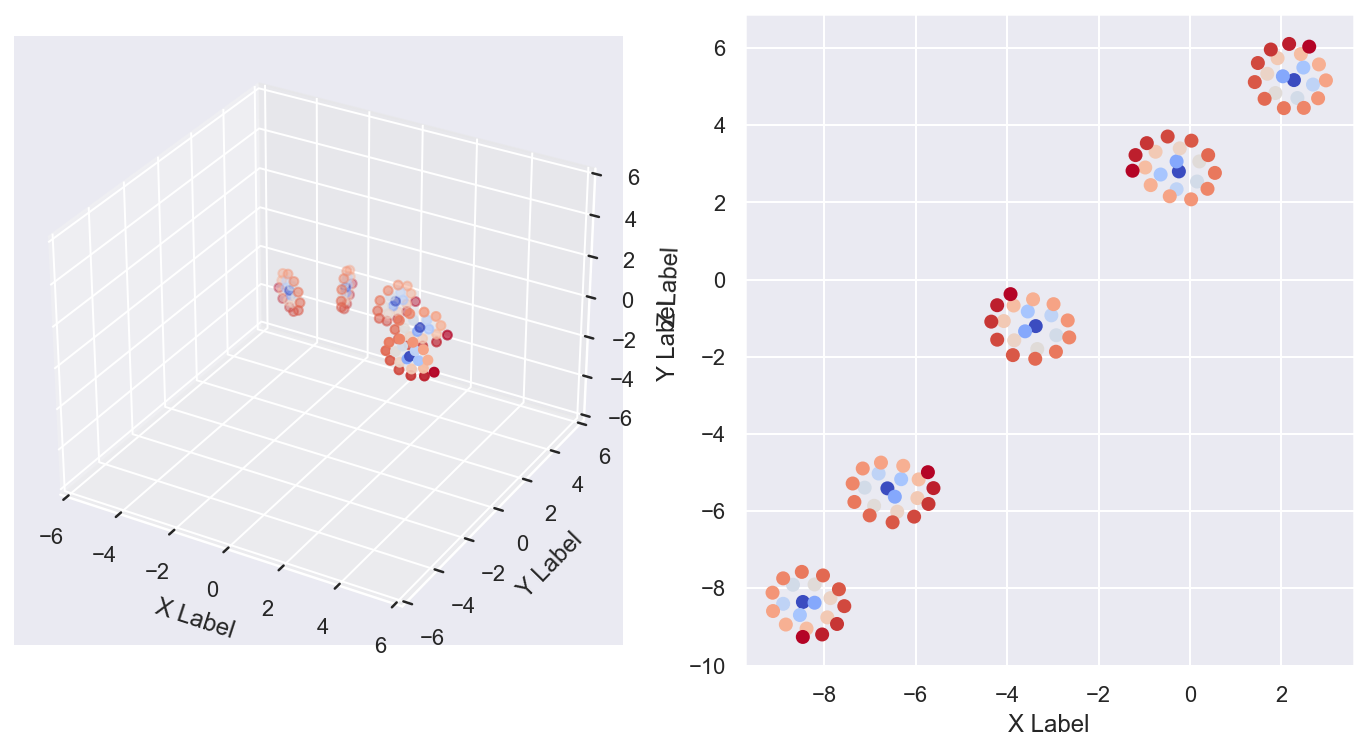

In [34]:
show_tSNE(spiral_density=3, spiral_steps = 20, width=3, angle=0.5, roll_density=5, n_neighbors=5,
              metric='euclidean', perplexity=30)

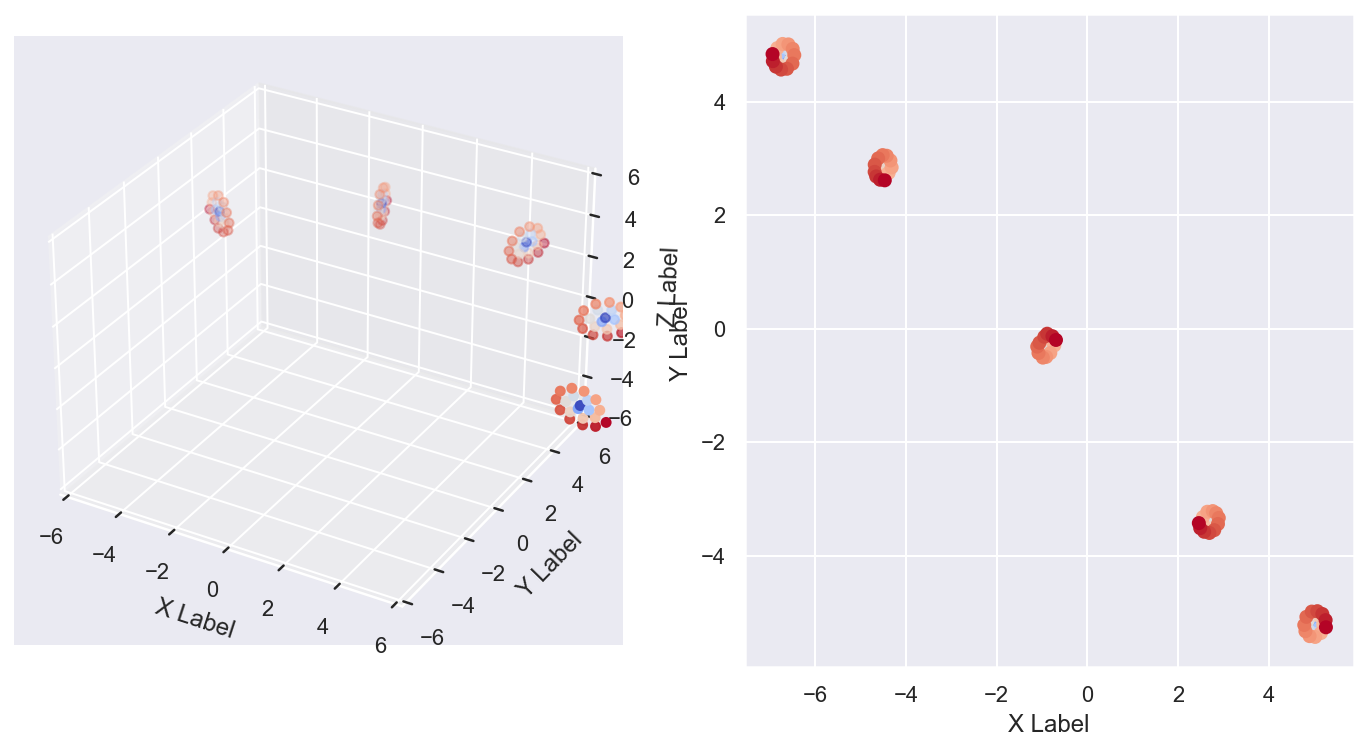

In [35]:
show_tSNE(spiral_density=3, spiral_steps = 20, width=9, angle=0.5, roll_density=5, n_neighbors=5,
              metric='euclidean', perplexity=30)

Zmiana odległości spiral od siebie nie zmienia kształtu wzajemnego położenia projekcji spiral, ani nie wpływa na kształt pojedynczej projekcji spirali. Jedyne co się zmienia od dystans projekcji spiral od siebie.

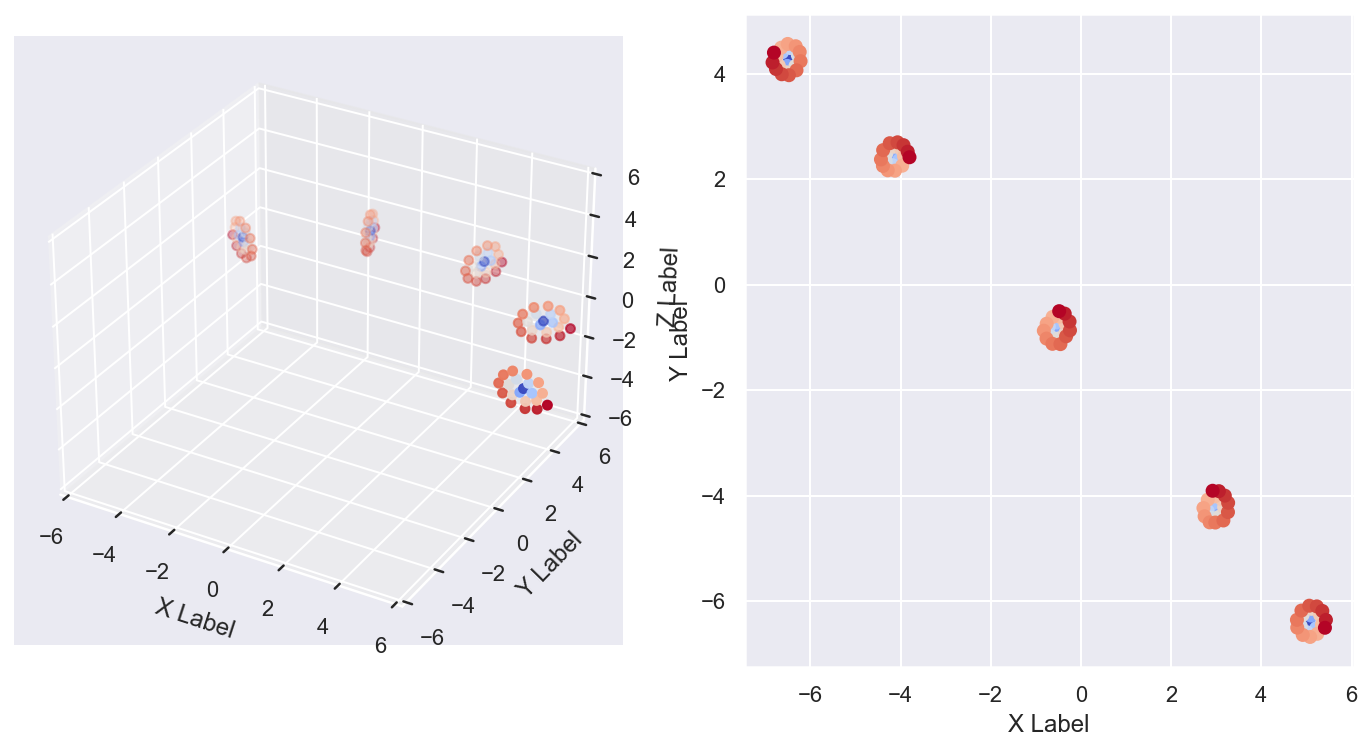

In [36]:
show_tSNE(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5, n_neighbors=5,
              metric='euclidean', perplexity=30)

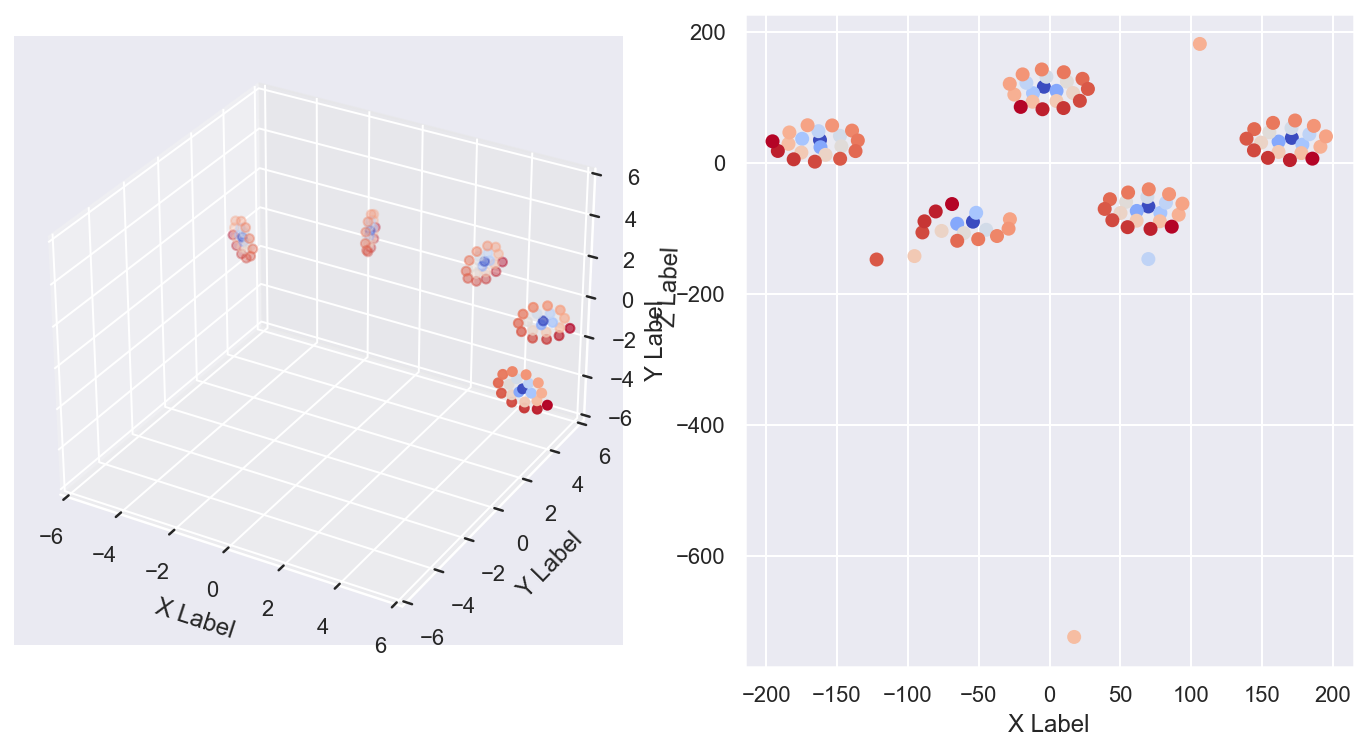

In [37]:
show_tSNE(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5, n_neighbors=5,
              metric='euclidean', perplexity=10)

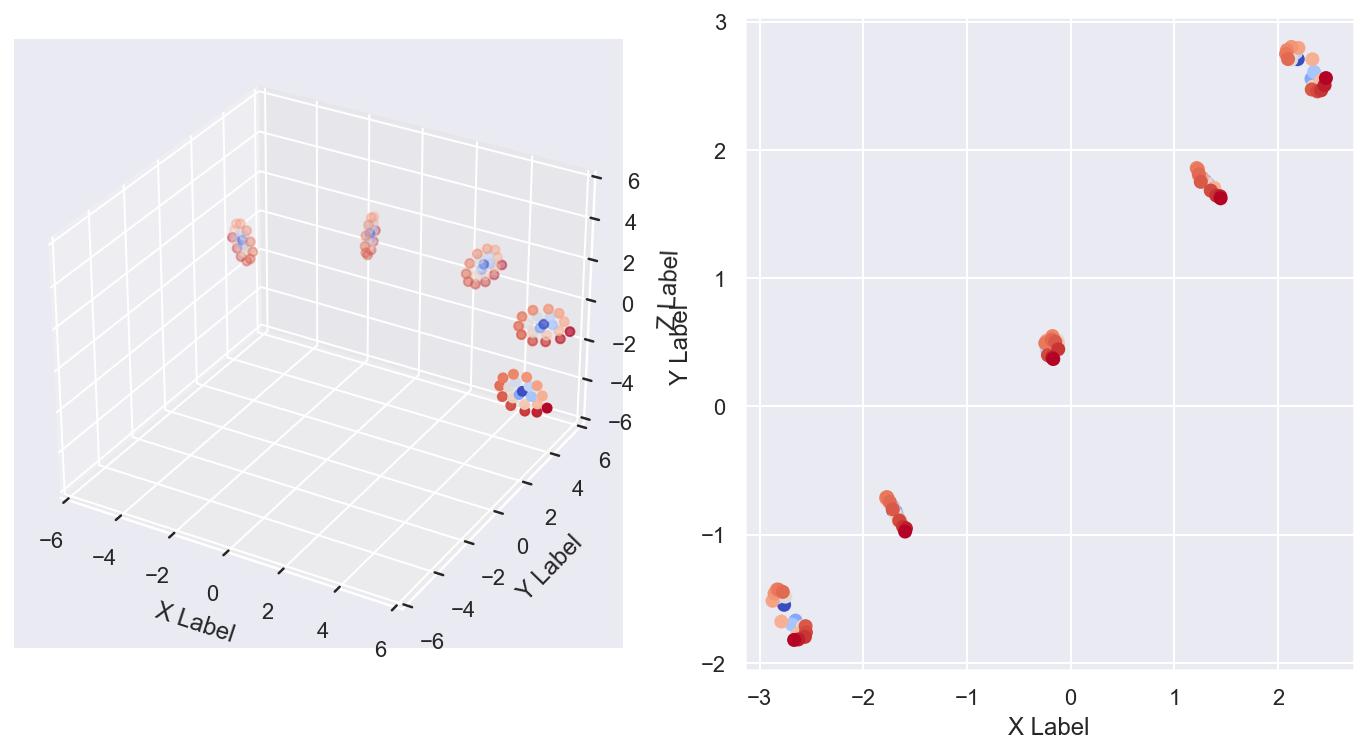

In [38]:
show_tSNE(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5, n_neighbors=5,
              metric='euclidean', perplexity=50)

Bardzo ciekawie wygląda zmiana parametru 'perplexity' przy identycznych parametrach wygenerowanego obrazu. Dla perplexity równym 30 spirale układają się w linii i zachowują okrągły kształt. Przy perplexity równym 10 - projekcje spiral układają się w coś w rodzaju pięciokąta i zachowują okrągły kształt, jednak pojedyncze punkty wypadają z projekcji. Dla perplexity o wartości 50 projekcji spiral znowu ustawiają się w jednej linii, jednak tym razem projekcja w centrum jest skupiona koło jednego punktu, a te na krańcach - rozproszone.  

### In this way, you should get a set of images showing the various available projections of the original roulade to the 2D plane. Treat these images as elements of a new data set, we treat image pixels as a high-dimensional vector. Use t-SNE to project the newly created set of 2d projection thumbnails into a 2-dimensional space.

In [39]:
from PIL import Image
from numpy import asarray
import os
import numpy as np

images = []
titles = []

for subdir, dirs, files in os.walk('.'):
    for file in files:
        if file.endswith(".png"):
           images = images + [asarray(Image.open(file))]
           titles = titles + [file]
images = np.array(images)

In [40]:
images.shape

(30, 326, 304, 4)

In [41]:
imgs_reshaped = images.reshape(images.shape[0], images.shape[1] * images.shape[2] * images.shape[3])

In [42]:
imgs_reshaped.shape

(30, 396416)

In [60]:
def title_to_num(elem):
    starts = ["pca", "kpca", "mde", "tsne"]
    for i, start in enumerate(starts):
        if elem.startswith(starts[i]):
            return i
    return len(starts)

In [96]:
def show_tSNE_imgs(xs,titles, metric, perplexity):
    from sklearn.manifold import TSNE
    colors = ['b', 'g', 'r', 'k']
    starts = ["pca", "kpca", "mde", "tsne"]
    titles_num = np.array([title_to_num(elem) for elem in titles])
    points_transformed = TSNE(n_components=2, metric=metric, perplexity=perplexity).fit_transform(xs)
    points_transformed_t = points_transformed.T
    
    
    plt.figure()
    for i in range(4):
        plt.scatter(points_transformed[i==titles_num, 0], points_transformed[i==titles_num, 1], c=colors[i])
    for i in range(len(titles)):
        plt.annotate(titles[i], (points_transformed_t[0, i], points_transformed_t[1,i]), fontsize=7)
    plt.legend(starts)
    plt.xlabel('X Label')
    plt.ylabel('Y Label')
    plt.show()    

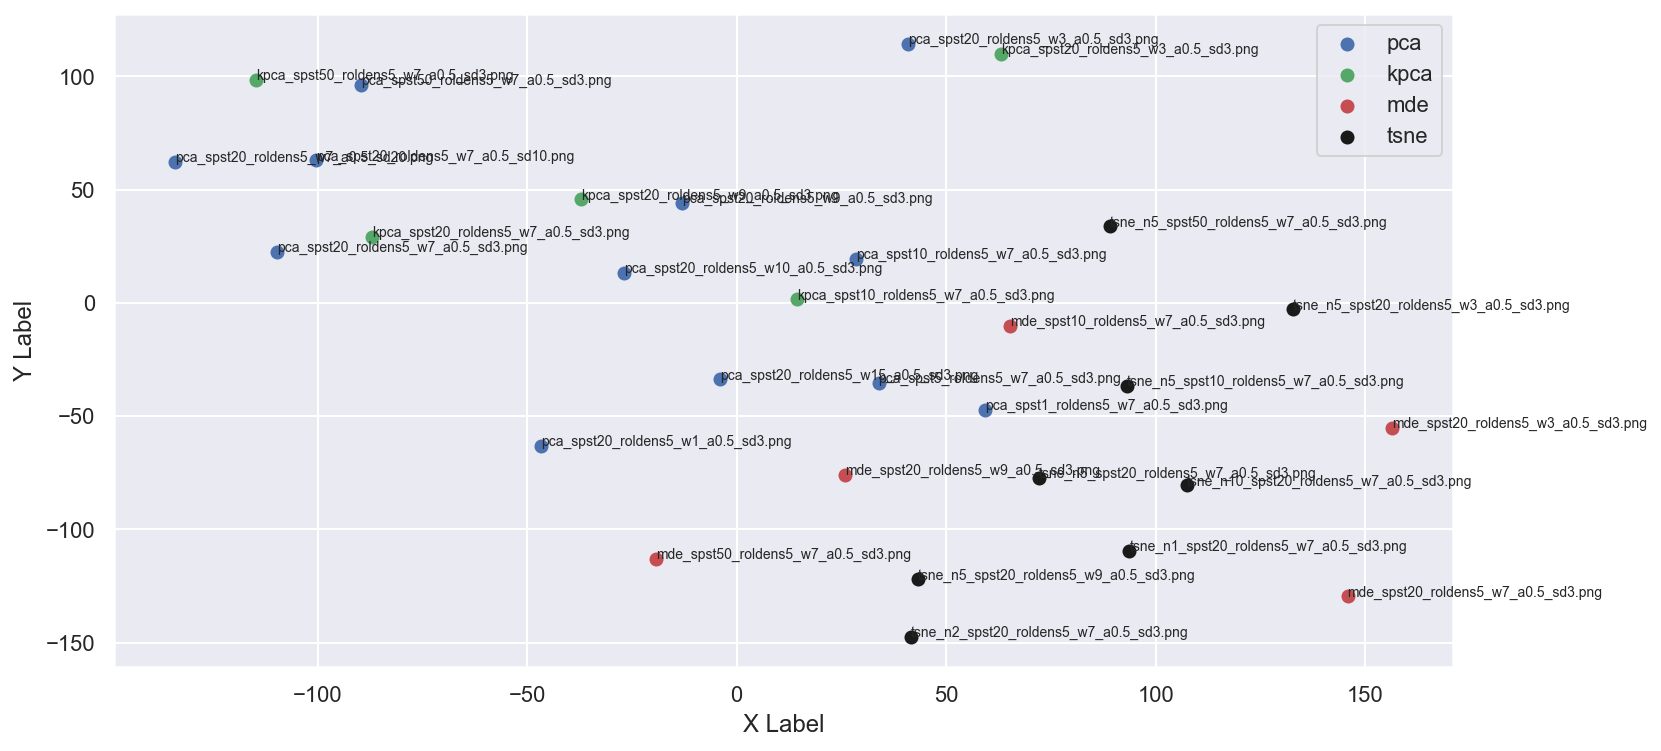

In [97]:
show_tSNE_imgs(imgs_reshaped, titles, 'euclidean', 10)

W ramach wizualizacji uporządkowano punktom kolor w zależności od metody, którą reprezentują.

Projekcje pca i kpca dla tych samych parametrów są do siebie bardzo zbliżone na wykresie. Wynika to z faktu, że użyliśmy liniowego kernela dla kPCA w związku z czym rezultaty projekcji pierwotengo obrazu były bardzo zbliżone. 

Z wykresu można też zauważyć, że projekcje dla tych samych metod znajdują się blisko siebie. Widać to szczególnie dla projekcji dokonanych metodą tsne. Podobne rezultaty są też dla PCA i kPCA w momencie gdy zaczniemy traktować je jako jedną metodę (z przyczyny podanej powyżej).

Z drugiej strony zbiór wizualizacji przy pomocy metody MDE, choć znajduje się w większości w z dala od innych punktów, to nie jest skupiony w jednej okolicy.

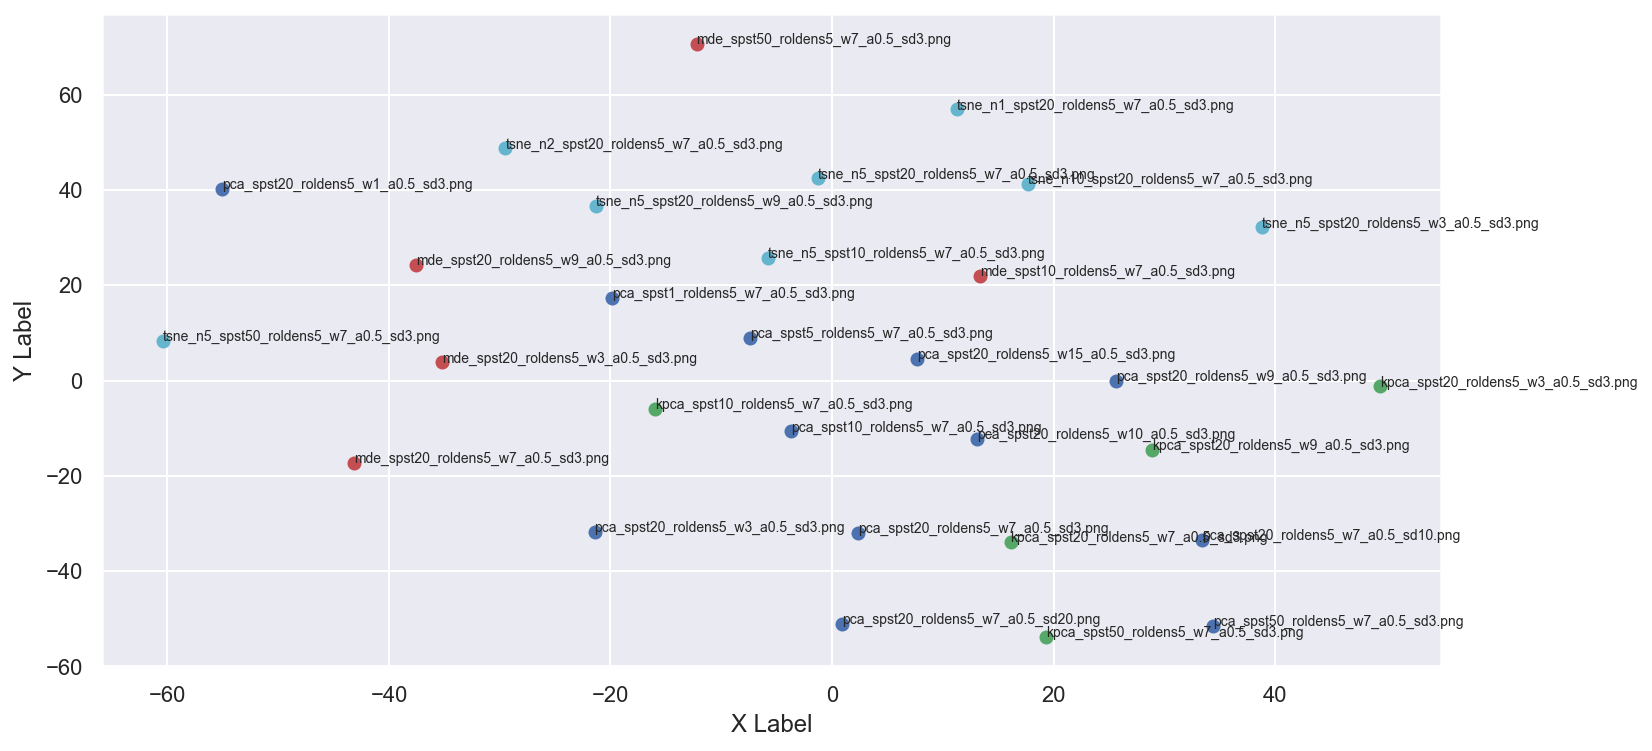

In [88]:
show_tSNE_imgs(imgs_reshaped, titles, 'euclidean', 20)

Zmiana parametru 'perplexity' na poziom 20 zmieniła trochę pozycje punktów na wykresie, jednak ich położenie względem siebie nie uległo dużym zmianom. 

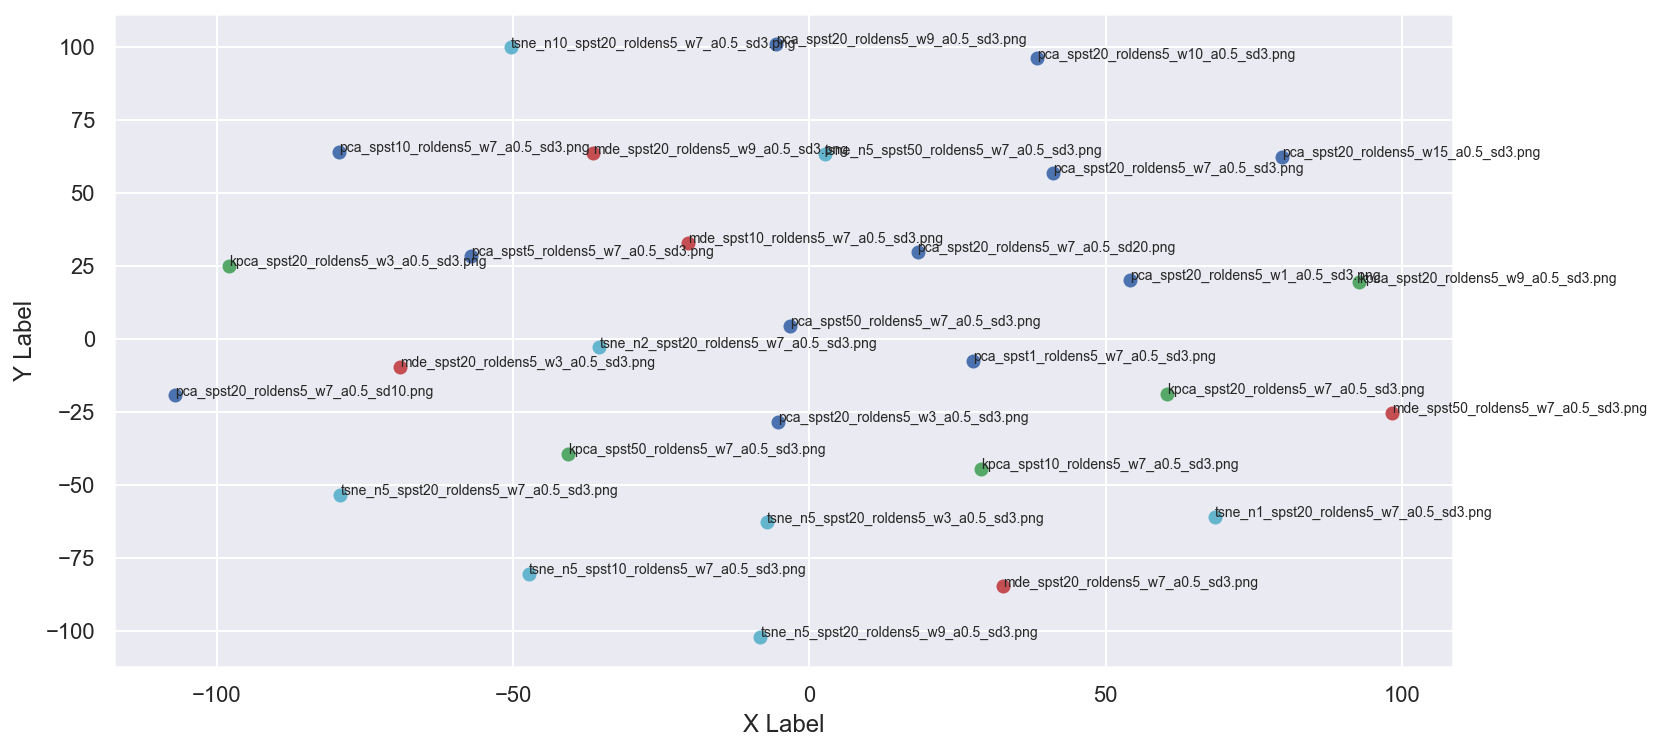

In [89]:
show_tSNE_imgs(imgs_reshaped, titles, 'euclidean', 50)

Podobnie zmiana 'perplexity' do wartości 50 niewiele zmienia. W tym przypadku punkty reprezentujące wizualizacje dokonane przy pomocy metody MDS znajdują się trochę bardziej w środku, jednak nadal nie są skupione w jednym miejscu.

# homework - work with more complex data (higher dimensionality).

- use a basic machine learning set representing black and white scans of 32x32 pixel handwritten digits (MNIST)
- apply dimensionality reduction on these data using PCA, MDS and t-SNE methods
- Plot results
- Pick first 1000-2000 points as TSNE takes a lot of time for all samples


In [47]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
print(x_train.shape)
print(y_train.shape)


(60000, 28, 28)
(60000,)


In [48]:
x_train = x_train[:1000]
y_train = y_train[:1000]

In [49]:
x_train_reshaped = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2] )
x_train_reshaped.shape

(1000, 784)

In [50]:
def show_PCA_mnist(xs, ys):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', '#ffb6c1', '#ff7f0e']
    from sklearn.decomposition import PCA
    embedding = PCA(n_components=2)
    points_transformed = embedding.fit_transform(xs)
    points_transformed_t = points_transformed.T
    
    targets = range(10)
    
    plt.figure()
    for i in targets:
        plt.scatter(points_transformed[ys==i, 0], points_transformed[ys==i, 1], c=colors[i])

    plt.xlabel('X Label')
    plt.ylabel('Y Label')
    plt.legend(targets)
    plt.show()
    

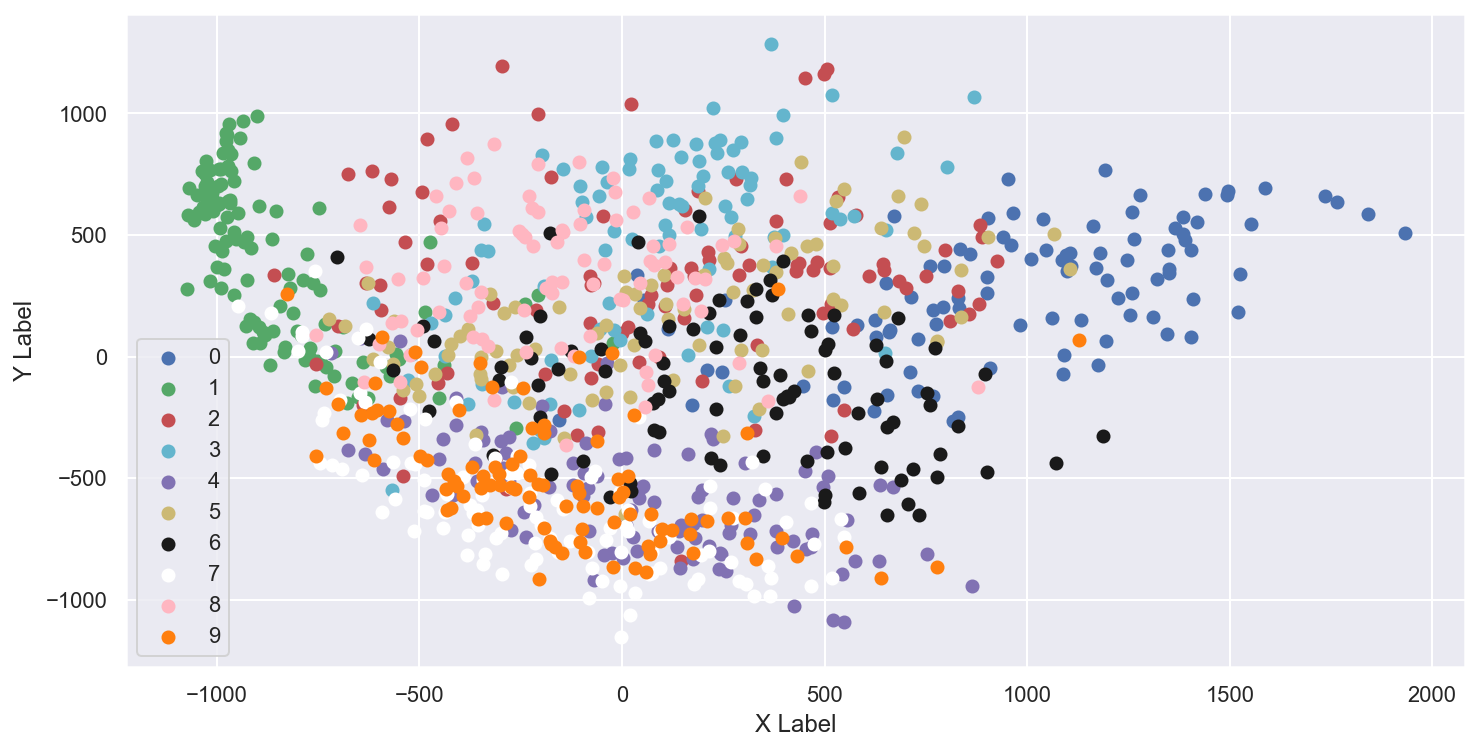

In [51]:
show_PCA_mnist(x_train_reshaped, y_train)

Skorzystanie z PCA daje dość słabe rezultaty. Udało się w większości rozdzielić obrazki reprezentujące cyfrę 1 i do pewnego stopnia - cyfrę 0. Dla pozostałych cyfr zbiory za bardzo zachodzą na siebie, choć widać, że w wielu przypadkach obrazy reprezentujące te same cyfry próbują się grupować w jednej części wykresu (np. dla cyfry 3 i 9).

In [52]:
def show_MDS_mnist(xs, ys):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', '#ffb6c1', '#ff7f0e']
    from sklearn.manifold import MDS
    embedding = MDS(n_components=2)
    points_transformed = embedding.fit_transform(xs)
    points_transformed_t = points_transformed.T
    
    targets = range(10)
    
    plt.figure()
    for i in targets:
        plt.scatter(points_transformed[ys==i, 0], points_transformed[ys==i, 1], c=colors[i])

    plt.xlabel('X Label')
    plt.ylabel('Y Label')
    plt.legend(targets)
    plt.show()    
    

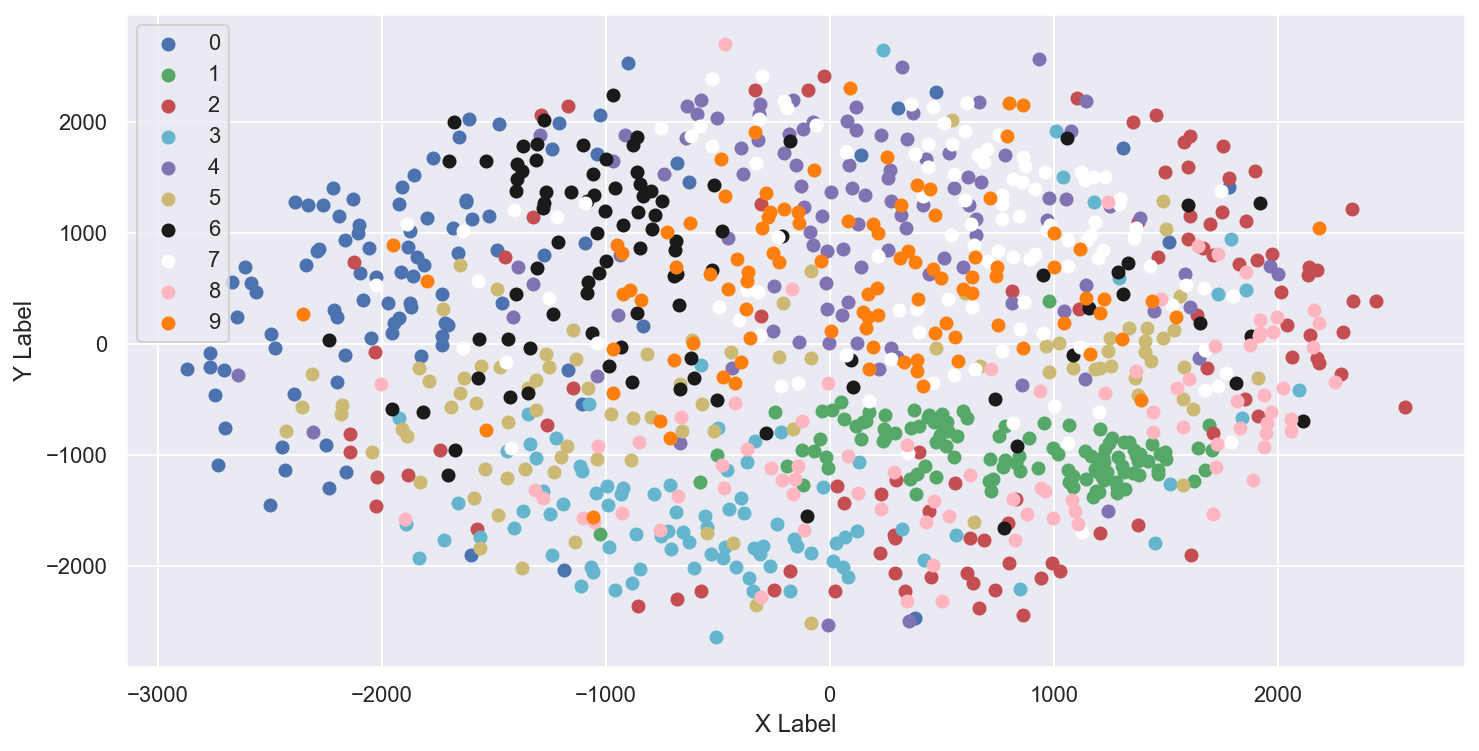

In [53]:
show_MDS_mnist(x_train_reshaped, y_train)

Przy użyciu MDS rozmieszczenie zbioru cyfr jest trochę bardziej uporządkowane niż dla PCA. Nadal najłatwiej rozdzielić zbiory obrazów reprezentujących cyfry 0 i 1. Pozostałe zbiory są trochę lepiej od siebie oddalone, choć widać, że np. punkty reprezentujące cyfrę 2 znajdują się zarówno po prawej stronie wykresu, jak i na dole (a niektóre punkty wręcz w okolicach lewego dolnego rogu).

In [54]:
def show_tSNE_mnist(xs, ys, metric, perplexity):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', '#ffb6c1', '#ff7f0e']
    from sklearn.manifold import TSNE
    points_transformed = TSNE(n_components=2, metric=metric, perplexity=perplexity).fit_transform(xs)
    points_transformed_t = points_transformed.T
    
    targets = range(10)
    
    plt.figure()
    for i in targets:
        plt.scatter(points_transformed[ys==i, 0], points_transformed[ys==i, 1], c=colors[i])

    plt.xlabel('X Label')
    plt.ylabel('Y Label')
    plt.legend(targets)
    plt.show()    

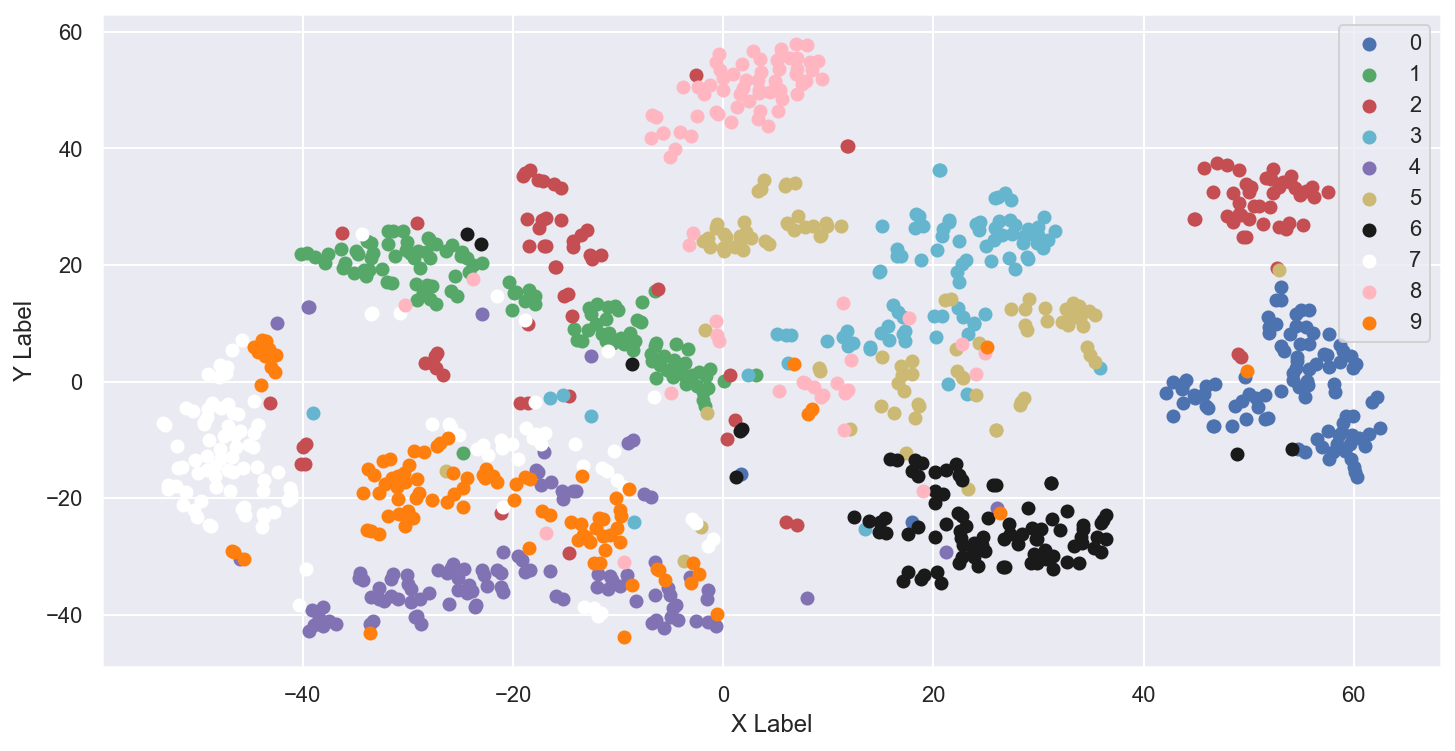

In [55]:
show_tSNE_mnist(x_train_reshaped, y_train, 'euclidean', 20)

Uzycie tSNE dało bardzo dobre rezultaty. Udało się rodzielić zbiory zawierający cyfry 0, 1, 6,7 czy 8. Jednocześnie zdarza się, że punkty reprezentujący tę samą cyfrę w większości grupują się w jednym zbiorze, ale część punktów znajduje się w zupełnie innych miejscach. Stało się tak choćby dla cyfry 2.

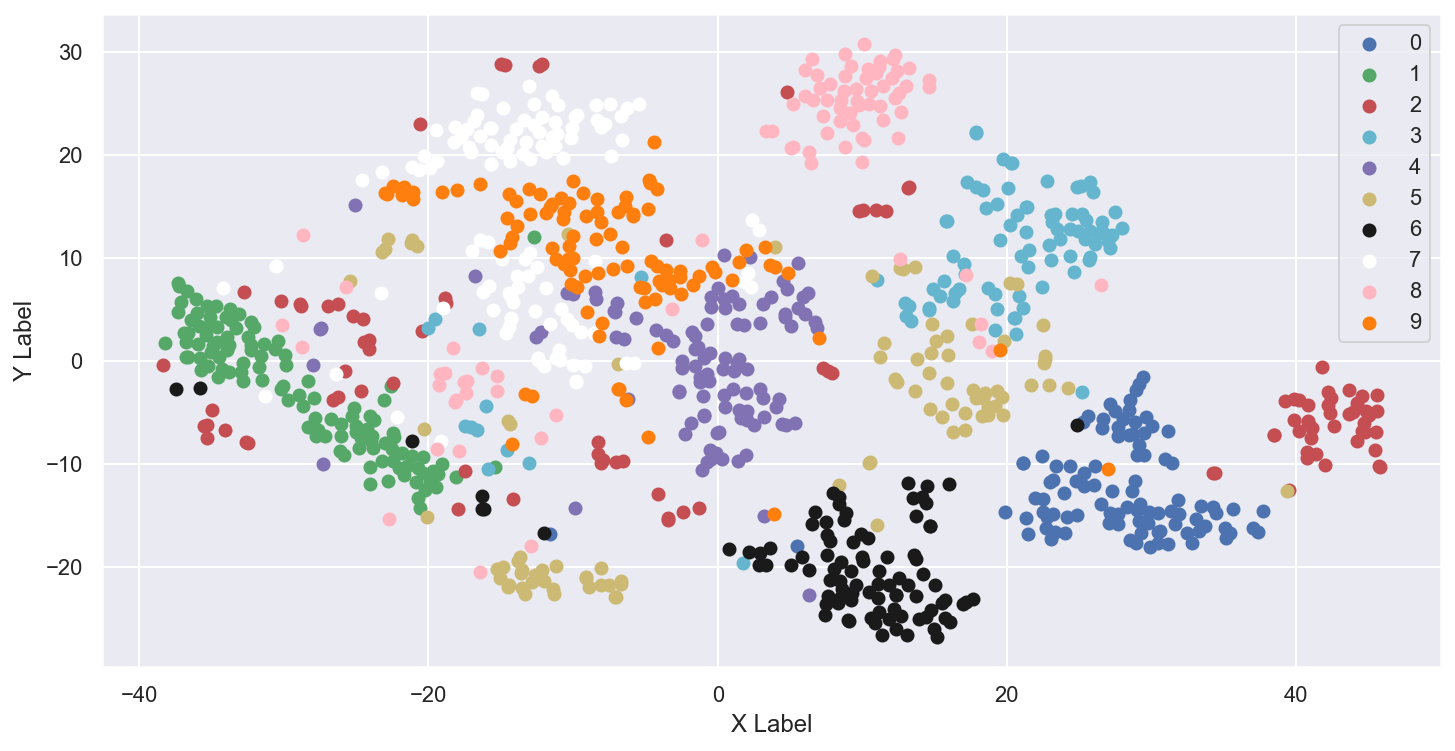

In [56]:
show_tSNE_mnist(x_train_reshaped, y_train, 'euclidean', 50)

Zwiększenie parametru 'perplexity' do 50 częściowo zmieniło wzajemne położenie zbiorów cyfr. Co prawda zbiory bordowe (2), granatowe (0) i czarne (6) nadal są obok siebie w tej samej kolejności, jednak zbiory różowe (8), białe (7), i zielone (1) zmieniły swoje wzajemne położenie w stosunku do wizualizacji tSNE z parametrem perplexity 20. Jednocześnie nadal zdarzają się przykłady punktów odległych od swoich zbiorów, więc jeśli nastąpiła poprawa w stosunku do wcześniejszej wizualizacji to jest ona niewielka.


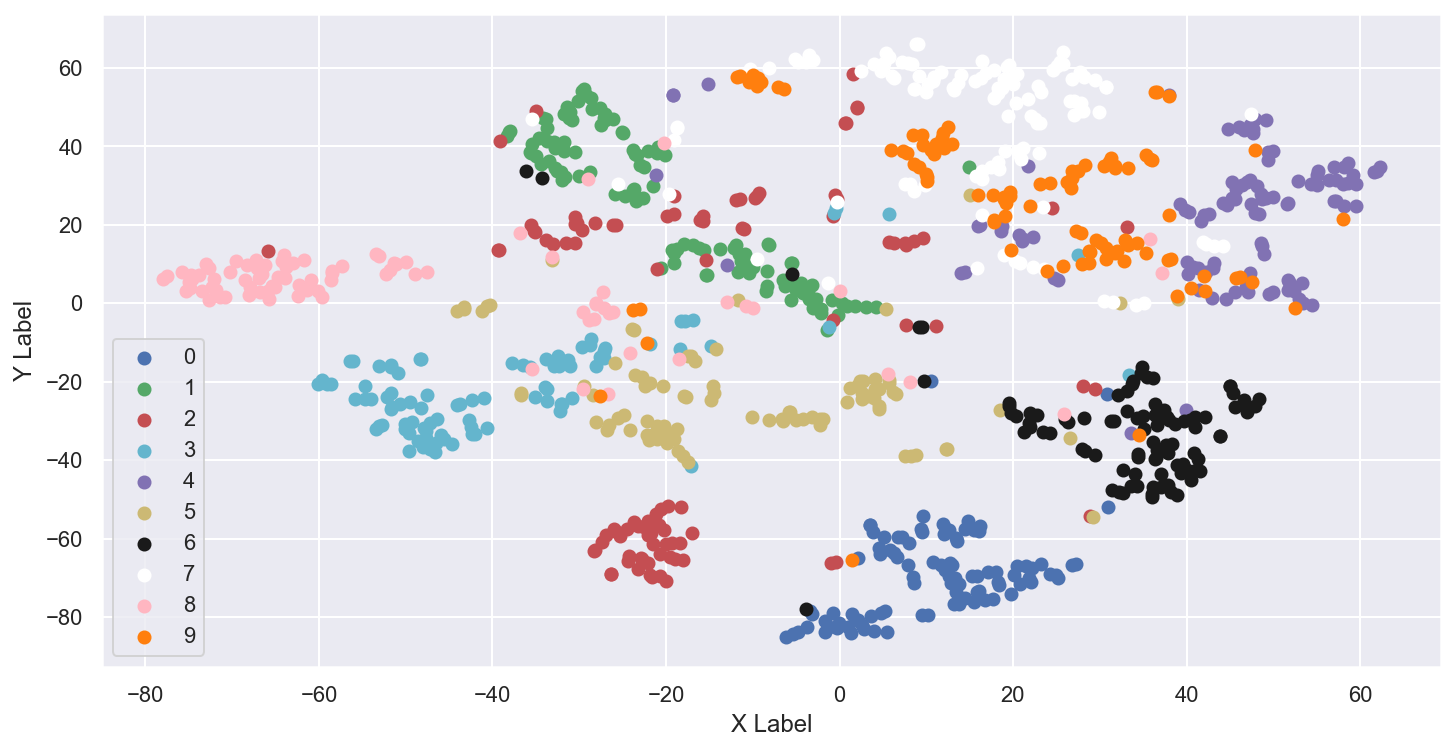

In [57]:
show_tSNE_mnist(x_train_reshaped, y_train, 'euclidean', 10)

Dla parametry 'perplexity' równemu 10 sytuacja nie zmieniła się znacznie. Wzajemne położenie zbiorów jest podobne co w poprzednich przykładach, choć trochę się różni. Nadal pojawiają się punkty odległe od swoich zbiorów. Bez względu na wybrane w przykładach parametry metoda tSNE daje znacznie lepsze rezultaty niż PCA czy MDS.